In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Neighborhoods

In [31]:
stations_raw = pd.read_csv("MTA_Subway_Stations_20241018.csv")

In [35]:
stations_gdf = gpd.GeoDataFrame(stations_raw, geometry=gpd.points_from_xy(stations_raw['GTFS Longitude'], stations_raw['GTFS Latitude']))
neighborhoods_gdf = gpd.read_file("Neighborhood Tabulation Areas.geojson")
stations = gpd.sjoin(stations_gdf, neighborhoods_gdf, how='left')[["GTFS Stop ID", "Station ID", "Complex ID", "Line", "Stop Name", "boro_name", "ntaname"]]

/var/folders/2z/znp5mbz57px8r00d9z3br30w0000gn/T/ipykernel_75754/3040887164.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  stations = gpd.sjoin(stations_gdf, neighborhoods_gdf, how='left')[["GTFS Stop ID", "Station ID", "Complex ID", "Line", "Stop Name", "boro_name", "ntaname"]]


In [42]:
daily_weather_summaries = pd.read_csv("open-meteo-40.74N74.04W51m.csv", skiprows=2)
daily_weather_summaries['time'] = pd.to_datetime(daily_weather_summaries['time'])
daily_weather_summaries["Hour of Day"] = daily_weather_summaries["time"].dt.hour

In [45]:
daily_weather_summaries.head()

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code),Hour of Day
0,2024-01-01 00:00:00,34.9,74,28.8,0.0,3,0
1,2024-01-01 01:00:00,34.8,76,28.1,0.0,3,1
2,2024-01-01 02:00:00,36.6,74,29.4,0.0,3,2
3,2024-01-01 03:00:00,36.8,74,30.1,0.0,3,3
4,2024-01-01 04:00:00,36.5,76,30.2,0.0,2,4


# Begin Morning Behavior

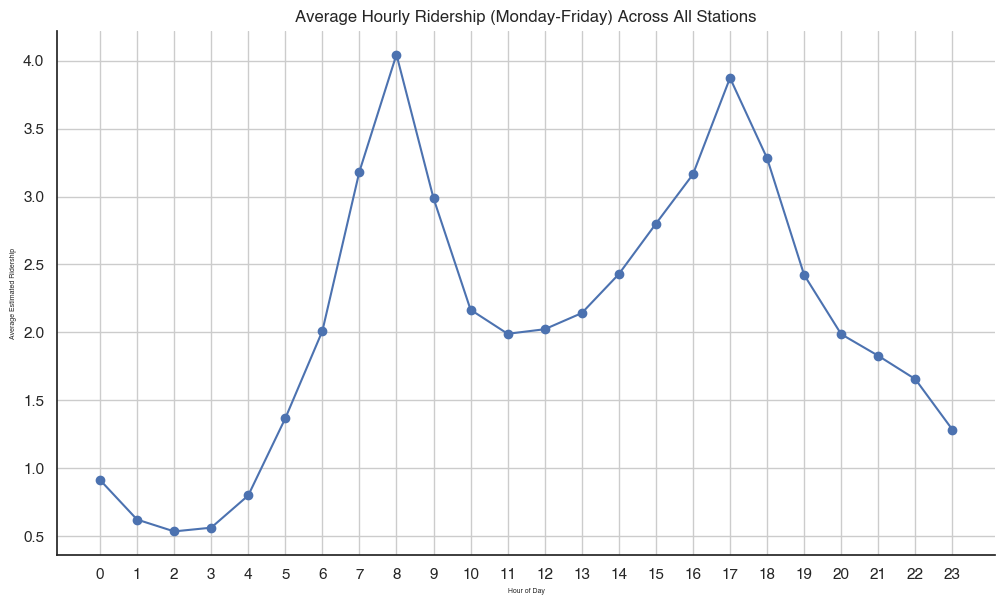

In [36]:
def plot_avg_ridership_weekdays(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = ['Hour of Day', 'Estimated Average Ridership', 'Day of Week']

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        # Filter for weekdays (Monday to Friday)
        weekdays_chunk = chunk[chunk['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
        results.append(weekdays_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and calculate the average ridership
    hourly_avg_ridership = final_result.groupby('Hour of Day')['Estimated Average Ridership'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_avg_ridership['Hour of Day'], hourly_avg_ridership['Estimated Average Ridership'], marker='o')
    plt.xticks(hourly_avg_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Estimated Ridership')
    plt.title('Average Hourly Ridership (Monday-Friday) Across All Stations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_ridership_weekdays()

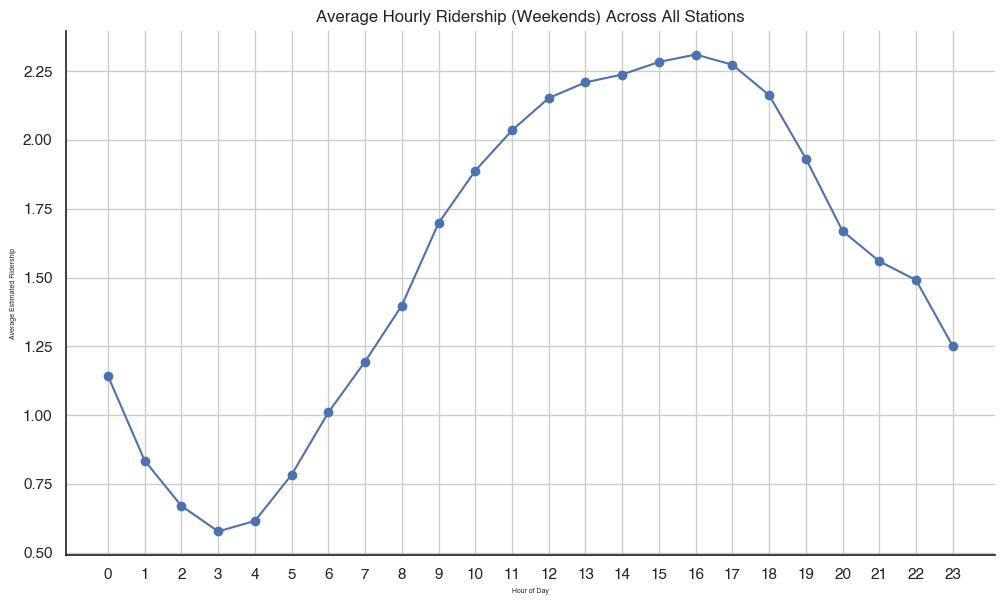

In [37]:
def plot_avg_ridership_weekdends(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = ['Hour of Day', 'Estimated Average Ridership', 'Day of Week']

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        # Filter for weekdays (Monday to Friday)
        weekdays_chunk = chunk[chunk['Day of Week'].isin(['Saturday', 'Sunday'])]
        results.append(weekdays_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and calculate the average ridership
    hourly_avg_ridership = final_result.groupby('Hour of Day')['Estimated Average Ridership'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_avg_ridership['Hour of Day'], hourly_avg_ridership['Estimated Average Ridership'], marker='o')
    plt.xticks(hourly_avg_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Estimated Ridership')
    plt.title('Average Hourly Ridership (Weekends) Across All Stations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_ridership_weekdends()

In [78]:
import pandas as pd

def select_dates_with_high_precipitation(daily_weather_summaries, threshold):
    # Ensure 'time' column is in datetime format
    daily_weather_summaries['time'] = pd.to_datetime(daily_weather_summaries['time'])

    # Extract the date from the 'time' column
    daily_weather_summaries['Date'] = daily_weather_summaries['time'].dt.date

    # Group by 'Date' and sum the precipitation
    daily_precipitation = daily_weather_summaries.groupby('Date')['precipitation (inch)'].sum().reset_index()

    # Convert 'Date' to datetime format
    daily_precipitation['Date'] = pd.to_datetime(daily_precipitation['Date'])

    # Filter dates where total precipitation is greater than the threshold
    precipitation_dates = daily_precipitation[daily_precipitation['precipitation (inch)'] > threshold]

    # Filter for weekdays
    precipitation_dates = precipitation_dates[precipitation_dates['Date'].dt.day_name().isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]

    return precipitation_dates['Date'].dt.date

precipitation_dates = select_dates_with_high_precipitation(daily_weather_summaries, threshold=0.2)
precipitation_dates.head()

8     2024-01-09
9     2024-01-10
15    2024-01-16
24    2024-01-25
32    2024-02-02
Name: Date, dtype: object

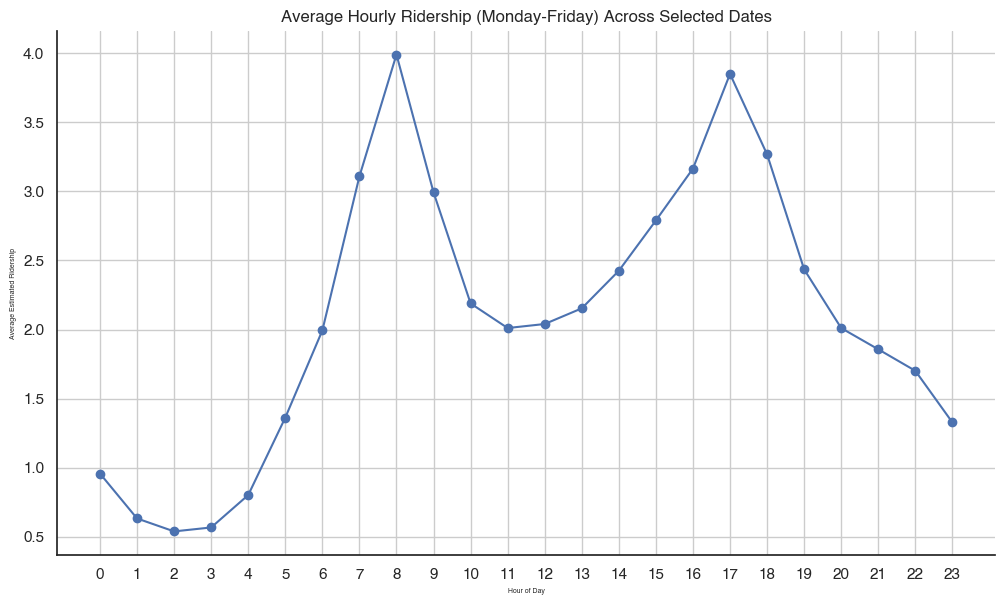

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_ridership_weekdays_with_precip(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000, date_list=None):
    if date_list is None:
        date_list = []

    results = []
    cols = ['Hour of Day', 'Estimated Average Ridership', 'Day of Week', 'Timestamp']

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        chunk["Timestamp"] = pd.to_datetime(chunk["Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

        # Filter for weekdays (Monday to Friday)
        weekdays_chunk = chunk[chunk['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

        # Filter for specific dates
        weekdays_chunk = weekdays_chunk[weekdays_chunk['Timestamp'].dt.date.isin(date_list)]

        results.append(weekdays_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and calculate the average ridership
    hourly_avg_ridership = final_result.groupby('Hour of Day')['Estimated Average Ridership'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_avg_ridership['Hour of Day'], hourly_avg_ridership['Estimated Average Ridership'], marker='o')
    plt.xticks(hourly_avg_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Estimated Ridership')
    plt.title('Average Hourly Ridership (Monday-Friday) Across Selected Dates')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
date_list = [pd.to_datetime(date).date() for date in precipitation_dates]
plot_avg_ridership_weekdays_with_precip(date_list=date_list)

In [83]:
# If want to, explore geo plot of ntanames and most popular morning destination.

# End Morning Behavior

# Begin Friday Nights

In [84]:
def calculate_friday_night_mean(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = [
        'Timestamp', 'Day of Week', 'Origin Station Complex ID', 
        'Destination Station Complex ID', 'Estimated Average Ridership'
    ]

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
        chunk['Hour'] = chunk['Timestamp'].dt.hour
        chunk['Date'] = chunk['Timestamp'].dt.date

        # Filter for Friday 9 PM to Saturday 4 AM using the Day of Week column
        friday_night_data = chunk[
            ((chunk['Day of Week'] == 'Friday') & (chunk['Hour'] >= 21)) |  # Friday 9 PM to midnight
            ((chunk['Day of Week'] == 'Saturday') & (chunk['Hour'] < 4))   # Saturday midnight to 4 AM
        ]

        # Group by origin/destination and calculate mean ridership for the chunk
        chunk_result = friday_night_data.groupby(
            ['Date', 'Origin Station Complex ID', 'Destination Station Complex ID']
        )['Estimated Average Ridership'].mean().reset_index()

        results.append(chunk_result)

    # Concatenate all chunk results
    all_results = pd.concat(results, ignore_index=True)

    # Group again to calculate the overall mean ridership across all chunks
    final_result = all_results.groupby(
        ['Date', 'Origin Station Complex ID', 'Destination Station Complex ID']
    )['Estimated Average Ridership'].mean().reset_index()

    return final_result

friday_nights_ridership = calculate_friday_night_mean()

In [90]:
friday_nights_ridership.head()

,Date,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership
0,2024-01-12,1,2,3.099833
1,2024-01-12,1,3,5.797167
2,2024-01-12,1,4,5.800333
3,2024-01-12,1,5,2.924433
4,2024-01-12,1,6,3.414333


In [120]:
ridership_by_complex = friday_nights_ridership.groupby('Destination Station Complex ID')['Estimated Average Ridership'].sum().reset_index()

# Merge with stations to get neighborhood information
merged_data = pd.merge(ridership_by_complex, stations, left_on='Destination Station Complex ID', right_on='Complex ID')

# Aggregate ridership by neighborhood
ridership_by_neighborhood = merged_data.groupby('ntaname')['Estimated Average Ridership'].sum().reset_index()

# Sort by ridership to find the neighborhoods with the highest ridership
ridership_by_neighborhood = ridership_by_neighborhood.sort_values(by='Estimated Average Ridership', ascending=False)

In [121]:
ridership_by_neighborhood.head()

,ntaname,Estimated Average Ridership
70,Midtown-Midtown South,253782.689500
3,Battery Park City-Lower Manhattan,75252.785350
55,Hudson Yards-Chelsea-Flatiron-Union Square,73171.018617
113,West Village,68581.073050
41,Elmhurst,59303.285208


In [106]:
import pandas as pd

friday_nights_ridership_with_neighborhood = friday_nights_ridership.merge(
    stations[['Complex ID', 'ntaname']],
    left_on='Origin Station Complex ID',
    right_on='Complex ID',
    how='left'
).rename(columns={'ntaname': 'Origin Neighborhood'}).drop(columns=['Complex ID'])

friday_nights_ridership_with_neighborhood = friday_nights_ridership_with_neighborhood.merge(
    stations[['Complex ID', 'ntaname']],
    left_on='Destination Station Complex ID',
    right_on='Complex ID',
    how='left'
).rename(columns={'ntaname': 'Destination Neighborhood'}).drop(columns=['Complex ID'])

friday_nights_ridership_with_neighborhood.head()

,Date,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership,Origin Neighborhood,Destination Neighborhood
0,2024-01-12,1,2,3.099833,Steinway,Steinway
1,2024-01-12,1,3,5.797167,Steinway,Astoria
2,2024-01-12,1,4,5.800333,Steinway,Astoria
3,2024-01-12,1,5,2.924433,Steinway,Astoria
4,2024-01-12,1,6,3.414333,Steinway,Queensbridge-Ravenswood-Long Island City


In [135]:
friday_ridership_by_destination = friday_nights_ridership.groupby('Destination Station Complex ID')['Estimated Average Ridership'].sum().reset_index()

merged_data = pd.merge(friday_ridership_by_destination, stations, left_on='Destination Station Complex ID', right_on='Complex ID')

friday_ridership_by_neighborhood = merged_data.groupby('ntaname')['Estimated Average Ridership'].sum().reset_index()

friday_ridership_by_neighborhood = friday_ridership_by_neighborhood.sort_values(by='Estimated Average Ridership', ascending=False)

friday_ridership_by_neighborhood.head()

,ntaname,Estimated Average Ridership
70,Midtown-Midtown South,253782.689500
3,Battery Park City-Lower Manhattan,75252.785350
55,Hudson Yards-Chelsea-Flatiron-Union Square,73171.018617
113,West Village,68581.073050
41,Elmhurst,59303.285208


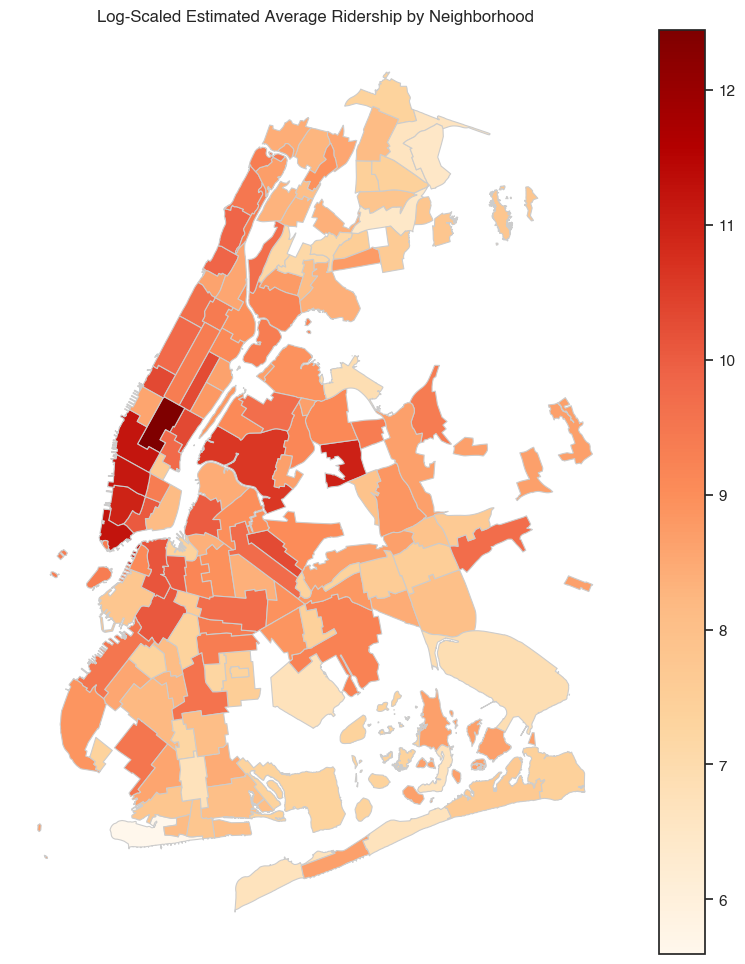

In [154]:
# If want plot each neighborhoods origin/destination on map
friday_neighborhood_estimations = pd.merge(neighborhoods_gdf, friday_ridership_by_neighborhood)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the DataFrame is already defined as 'geo_data'
# Convert the DataFrame to a GeoDataFrame
geo_data = gpd.GeoDataFrame(friday_neighborhood_estimations, geometry='geometry')

# Add a new column for log-transformed ridership
geo_data['Log Estimated Average Ridership'] = np.log1p(geo_data['Estimated Average Ridership'])

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
geo_data.plot(column='Log Estimated Average Ridership', 
              cmap='OrRd', 
              linewidth=0.8, 
              ax=ax, 
              edgecolor='0.8', 
              legend=True
             )

# Customize the plot
ax.set_title('Log-Scaled Estimated Average Ridership by Neighborhood')
ax.set_axis_off()

plt.show()

In [156]:
import pandas as pd

# Assuming daily_weather_summaries is already loaded

# Convert time to datetime
daily_weather_summaries['datetime'] = pd.to_datetime(daily_weather_summaries['time'])

# Filter for Friday 9 PM to Saturday 4 AM
friday_night_weather_summaries = daily_weather_summaries[
    ((daily_weather_summaries['datetime'].dt.weekday == 4) & (daily_weather_summaries['datetime'].dt.hour >= 21)) |
    ((daily_weather_summaries['datetime'].dt.weekday == 5) & (daily_weather_summaries['datetime'].dt.hour < 4))
]

# Group by date (using Friday's date)
friday_night_weather_summaries = friday_night_weather_summaries.groupby(friday_night_weather_summaries['datetime'].dt.date)

# Aggregate max temp, min temp, and total precipitation
friday_night_weather_summaries = friday_night_weather_summaries.agg({
    'temperature_2m (°F)': ['max', 'min'],
    'precipitation (inch)': 'sum'
}).reset_index()

friday_night_weather_summaries.columns = ['Date', 'max_temp', 'min_temp', 'total_precip']
friday_night_weather_summaries.head()

,Date,max_temp,min_temp,total_precip
0,2024-01-05,29.8,27.0,0.000
1,2024-01-06,25.7,23.7,0.000
2,2024-01-12,43.7,42.8,0.032
3,2024-01-13,50.1,44.6,0.603
4,2024-01-19,24.5,23.4,0.000


In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

friday_night_ridership_and_weather = pd.merge(friday_nights_ridership, friday_night_weather_summaries, on="Date")

cold_or_wet_weather = (
    (friday_night_ridership_and_weather['total_precip'] > 0.5) |
    (friday_night_ridership_and_weather['min_temp'] < 32)
)

avg_ridership_bad_weather = friday_night_ridership_and_weather[cold_or_wet_weather]['Estimated Average Ridership'].mean()
avg_ridership_normal_weather = friday_night_ridership_and_weather[~cold_or_wet_weather]['Estimated Average Ridership'].mean()

percent_decrease = ((avg_ridership_normal_weather - avg_ridership_bad_weather) / avg_ridership_normal_weather) * 100

print("%.2f%% decrease in cold or wet conditions" % percent_decrease)

33.63% decrease in cold or wet conditions


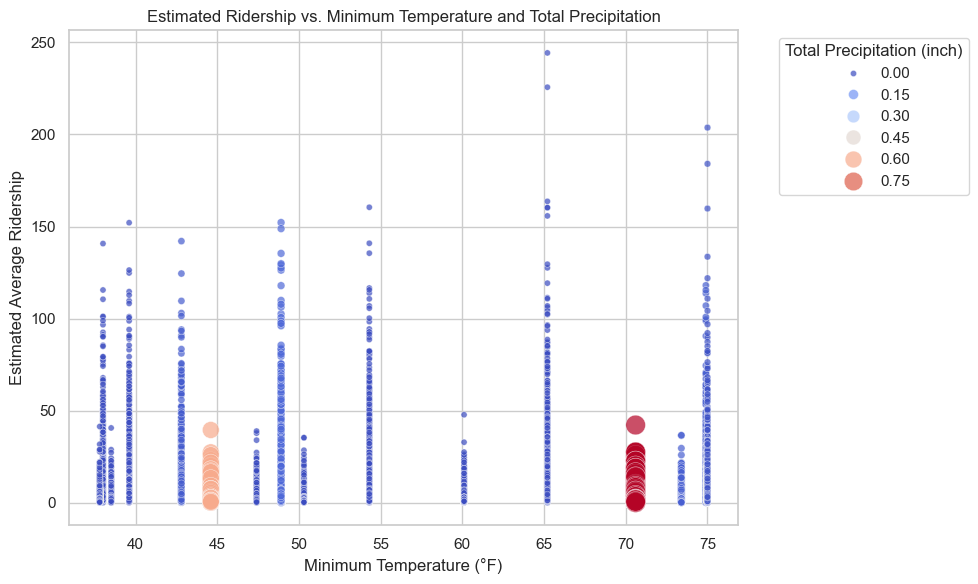

In [208]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=friday_night_ridership_and_weather,
    x='min_temp',
    y='Estimated Average Ridership',
    size='total_precip',
    hue='total_precip',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7
)

plt.title('Estimated Ridership vs. Minimum Temperature and Total Precipitation')
plt.xlabel('Minimum Temperature (°F)')
plt.ylabel('Estimated Average Ridership')
plt.legend(title='Total Precipitation (inch)', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

# End Friday Nights

# Begin Beach Day

# End Beach Day

### Helpers

We'll define some functions here that'll help us in our analysis in the future.

In [33]:
MTA_SUBWAY_RIDERSHIP_FILENAME = "MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv"

In [34]:
def select_ridership_by_stations(station_ids, file_path=MTA_SUBWAY_RIDERSHIP_FILENAME, chunksize=100000, is_origin=True):
    results = []
    cols = [
        'Day of Week', 'Timestamp', 'Origin Station Complex ID', 'Origin Station Complex Name', 
        'Destination Station Complex ID', 'Destination Station Complex Name',
        'Estimated Average Ridership'
    ]

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        # Filter for the specified station IDs in either origin or destination
        if is_origin:
            processed_chunk = chunk[chunk['Origin Station Complex ID'].isin(station_ids)]
        else:
            processed_chunk = chunk[chunk['Destination Station Complex ID'].isin(station_ids)]
        results.append(processed_chunk)

    final_result = pd.concat(results, ignore_index=True)

    return final_result

In [21]:
# TODO: organize and make cleaner
def join_chunk_by_ntaname(chunk, stations, ntaname, is_origin):
    # Filter stations by ntaname
    relevant_stations = stations[stations['ntaname'] == ntaname]
    relevant_ids = relevant_stations['Complex ID'].unique()

    # Filter chunk for relevant origin or destination stations
    if is_origin:
        filtered_chunk = chunk[
            chunk['Origin Station Complex ID'].isin(relevant_ids)
        ]
    else:
        filtered_chunk = chunk[
            chunk['Destination Station Complex ID'].isin(relevant_ids)
        ]

    return filtered_chunk

def process_large_csv(file_path, stations, ntaname, chunksize=100000, is_origin=True):
    results = []
    cols = [
        'Day of Week', 'Timestamp', 'Origin Station Complex ID', 'Origin Station Complex Name', 
        'Destination Station Complex ID', 'Destination Station Complex Name',
        'Estimated Average Ridership'
    ]
    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        processed_chunk = join_chunk_by_ntaname(chunk, stations, ntaname, is_origin)
        results.append(processed_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)
    final_result["Timestamp"] = pd.to_datetime(final_result["Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
    return final_result

select_by_ntaname = lambda n, is_origin=True: process_large_csv("MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", stations, n, is_origin=is_origin)

In [22]:
def group_chunk_by_date(chunk):
    chunk['Date'] = pd.to_datetime(chunk['Timestamp'], format="%m/%d/%Y %I:%M:%S %p").dt.date
    grouped_chunk = chunk.groupby(['Date', 'Origin Station Complex ID', 'Destination Station Complex ID'])['Estimated Average Ridership'].sum().reset_index()
    return grouped_chunk

def group_ridership_by_date(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = [
        'Day of Week', 'Timestamp', 'Origin Station Complex ID', 'Origin Station Complex Name', 
        'Destination Station Complex ID', 'Destination Station Complex Name',
        'Estimated Average Ridership'
    ]
    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        processed_chunk = group_chunk_by_date(chunk)
        results.append(processed_chunk)

    final_result = pd.concat(results, ignore_index=True)

    final_result = final_result.groupby(['Date', 'Origin Station Complex ID', 'Destination Station Complex ID'])['Estimated Average Ridership'].sum().reset_index()
    return final_result

### Plot helpers

In [23]:
def plot_ridership_for_stations(station_ids, date_str, file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", is_origin=True, chunksize=100000):
    results = []
    cols = [
        'Timestamp', 'Origin Station Complex ID', 'Destination Station Complex ID',
        'Estimated Average Ridership', 'Hour of Day'
    ]

    # Convert date string to datetime
    target_date = pd.to_datetime(date_str, format="%Y-%m-%d").date()

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], format="%m/%d/%Y %I:%M:%S %p")

        # Filter by station IDs and date
        if is_origin:
            filtered_chunk = chunk[
                (chunk['Origin Station Complex ID'].isin(station_ids)) &
                (chunk['Timestamp'].dt.date == target_date)
            ]
        else:
            filtered_chunk = chunk[
                (chunk['Destination Station Complex ID'].isin(station_ids)) &
                (chunk['Timestamp'].dt.date == target_date)
            ]

        results.append(filtered_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and station ID, summing the ridership
    if is_origin:
        group_cols = ['Hour of Day', 'Origin Station Complex ID']
    else:
        group_cols = ['Hour of Day', 'Destination Station Complex ID']

    hourly_ridership = final_result.groupby(group_cols)['Estimated Average Ridership'].sum().reset_index()

    # Plotting
    plt.figure(figsize=(5, 3))
    for station_id in station_ids:
        if is_origin:
            station_data = hourly_ridership[hourly_ridership['Origin Station Complex ID'] == station_id]
        else:
            station_data = hourly_ridership[hourly_ridership['Destination Station Complex ID'] == station_id]

        plt.plot(station_data['Hour of Day'], station_data['Estimated Average Ridership'], marker='o', label=f'Station {station_id}')

    plt.xticks(hourly_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Estimated Average Ridership')
    plt.title(f'Hourly Ridership on {date_str}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:
daily_ridership = group_ridership_by_date()
daily_ridership["Date"] = pd.to_datetime(daily_ridership["Date"], format="%Y-%m-%d")

In [172]:
def calculate_friday_night_mean(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = [
        'Timestamp', 'Day of Week', 'Origin Station Complex ID', 
        'Destination Station Complex ID', 'Estimated Average Ridership'
    ]

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
        chunk['Hour'] = chunk['Timestamp'].dt.hour
        chunk['Date'] = chunk['Timestamp'].dt.date

        # Filter for Friday 9 PM to Saturday 4 AM using the Day of Week column
        friday_night_data = chunk[
            ((chunk['Day of Week'] == 'Friday') & (chunk['Hour'] >= 21)) |  # Friday 9 PM to midnight
            ((chunk['Day of Week'] == 'Saturday') & (chunk['Hour'] < 4))   # Saturday midnight to 4 AM
        ]

        # Group by origin/destination and calculate mean ridership for the chunk
        chunk_result = friday_night_data.groupby(
            ['Date', 'Origin Station Complex ID', 'Destination Station Complex ID']
        )['Estimated Average Ridership'].mean().reset_index()

        results.append(chunk_result)

    # Concatenate all chunk results
    all_results = pd.concat(results, ignore_index=True)

    # Group again to calculate the overall mean ridership across all chunks
    final_result = all_results.groupby(
        ['Date', 'Origin Station Complex ID', 'Destination Station Complex ID']
    )['Estimated Average Ridership'].mean().reset_index()

    return final_result

friday_nights_ridership = calculate_friday_night_mean()

In [146]:
ridership_by_complex = friday_nights_ridership.groupby('Destination Station Complex ID')['Estimated Average Ridership'].sum().reset_index()

# Merge with stations to get neighborhood information
merged_data = pd.merge(ridership_by_complex, stations, left_on='Destination Station Complex ID', right_on='Complex ID')

# Aggregate ridership by neighborhood
ridership_by_neighborhood = merged_data.groupby('ntaname')['Estimated Average Ridership'].sum().reset_index()

# Sort by ridership to find the neighborhoods with the highest ridership
ridership_by_neighborhood = ridership_by_neighborhood.sort_values(by='Estimated Average Ridership', ascending=False)

In [147]:
ridership_by_neighborhood

,ntaname,Estimated Average Ridership
70,Midtown-Midtown South,253782.689500
3,Battery Park City-Lower Manhattan,75252.785350
55,Hudson Yards-Chelsea-Flatiron-Union Square,73171.018617
113,West Village,68581.073050
41,Elmhurst,59303.285208
...,...,...
10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,792.773742
40,Eastchester-Edenwald-Baychester,752.983575
25,Co-op City,654.700575
107,Van Nest-Morris Park-Westchester Square,632.670950


In [148]:
origin_merged = pd.merge(friday_nights_ridership, stations, left_on='Origin Station Complex ID', right_on='Complex ID')
origin_merged = origin_merged.rename(columns={'ntaname': 'Origin Neighborhood'})

# Merge to get destination neighborhood
full_merged = pd.merge(origin_merged, stations, left_on='Destination Station Complex ID', right_on='Complex ID')
full_merged = full_merged.rename(columns={'ntaname': 'Destination Neighborhood'})

# Aggregate ridership by origin and destination neighborhoods
ridership_by_neighborhoods = full_merged.groupby(
    ['Origin Neighborhood', 'Destination Neighborhood']
)['Estimated Average Ridership'].sum().reset_index()

# Sort to find the most popular origin-destination neighborhood pair
ridership_by_neighborhoods = ridership_by_neighborhoods.sort_values(by='Estimated Average Ridership', ascending=False)

In [149]:
ridership_by_neighborhoods

,Origin Neighborhood,Destination Neighborhood,Estimated Average Ridership
8517,Midtown-Midtown South,Midtown-Midtown South,70668.495083
8450,Midtown-Midtown South,Battery Park City-Lower Manhattan,48196.150208
13711,West Village,Midtown-Midtown South,40920.843942
6676,Hudson Yards-Chelsea-Flatiron-Union Square,Midtown-Midtown South,38912.751542
8502,Midtown-Midtown South,Hudson Yards-Chelsea-Flatiron-Union Square,37110.773133
...,...,...,...
9798,Ocean Parkway South,Airport,0.200000
11191,Seagate-Coney Island,Williamsbridge-Olinville,0.200000
10775,Rego Park,Canarsie,0.200000
2303,Carroll Gardens-Columbia Street-Red Hook,Crotona Park East,0.200000


In [150]:
destination_merged = pd.merge(friday_nights_ridership, stations, left_on='Destination Station Complex ID', right_on='Complex ID')
destination_merged = destination_merged.rename(columns={'ntaname': 'Destination Neighborhood'})

# Aggregate ridership by destination neighborhood
ridership_by_destination_neighborhood = destination_merged.groupby('Destination Neighborhood')['Estimated Average Ridership'].sum().reset_index()

# Sort to find the top destination neighborhoods
ridership_by_destination_neighborhood = ridership_by_destination_neighborhood.sort_values(by='Estimated Average Ridership', ascending=False)

In [174]:
ridership_by_destination_neighborhood.head()

,Destination Neighborhood,Estimated Average Ridership
70,Midtown-Midtown South,253782.689500
3,Battery Park City-Lower Manhattan,75252.785350
55,Hudson Yards-Chelsea-Flatiron-Union Square,73171.018617
113,West Village,68581.073050
41,Elmhurst,59303.285208


In [173]:
def calculate_day_night_mean(day, day2, file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = [
        'Timestamp', 'Day of Week', 'Origin Station Complex ID', 
        'Destination Station Complex ID', 'Estimated Average Ridership'
    ]

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
        chunk['Hour'] = chunk['Timestamp'].dt.hour
        chunk['Date'] = chunk['Timestamp'].dt.date

        saturday_night_data = chunk[
            ((chunk['Day of Week'] == day) & (chunk['Hour'] >= 21)) |
            ((chunk['Day of Week'] == day2) & (chunk['Hour'] < 4))
        ]

        # Group by origin/destination and calculate mean ridership for the chunk
        chunk_result = saturday_night_data.groupby(
            ['Date', 'Origin Station Complex ID', 'Destination Station Complex ID']
        )['Estimated Average Ridership'].mean().reset_index()

        results.append(chunk_result)

    # Concatenate all chunk results
    all_results = pd.concat(results, ignore_index=True)

    # Group again to calculate the overall mean ridership across all chunks
    final_result = all_results.groupby(
        ['Date', 'Origin Station Complex ID', 'Destination Station Complex ID']
    )['Estimated Average Ridership'].mean().reset_index()

    return final_result

In [180]:
tuesday_nights_ridership = calculate_day_night_mean("Saturday", "Sunday")
tues_destination_merged = pd.merge(tuesday_nights_ridership, stations, left_on='Destination Station Complex ID', right_on='Complex ID')
tues_destination_merged = tues_destination_merged.rename(columns={'ntaname': 'Destination Neighborhood'})

# Aggregate ridership by destination neighborhood
tues_ridership_by_destination_neighborhood = tues_destination_merged.groupby('Destination Neighborhood')['Estimated Average Ridership'].sum().reset_index()

# Sort to find the top destination neighborhoods
tues_ridership_by_destination_neighborhood = tues_ridership_by_destination_neighborhood.sort_values(by='Estimated Average Ridership', ascending=False)

In [181]:
tues_ridership_by_destination_neighborhood.head()

,Destination Neighborhood,Estimated Average Ridership
70,Midtown-Midtown South,231187.107425
3,Battery Park City-Lower Manhattan,69222.000367
55,Hudson Yards-Chelsea-Flatiron-Union Square,67617.134883
113,West Village,63950.168833
94,SoHo-TriBeCa-Civic Center-Little Italy,53748.841408


In [182]:
ridership_by_destination_neighborhood.head()

,Destination Neighborhood,Estimated Average Ridership
70,Midtown-Midtown South,253782.689500
3,Battery Park City-Lower Manhattan,75252.785350
55,Hudson Yards-Chelsea-Flatiron-Union Square,73171.018617
113,West Village,68581.073050
41,Elmhurst,59303.285208


In [183]:
sun_nights_ridership = calculate_day_night_mean("Sunday", "Monday")
sun_destination_merged = pd.merge(sun_nights_ridership, stations, left_on='Destination Station Complex ID', right_on='Complex ID')
sun_destination_merged = sun_destination_merged.rename(columns={'ntaname': 'Destination Neighborhood'})

# Aggregate ridership by destination neighborhood
sun_ridership_by_destination_neighborhood = sun_destination_merged.groupby('Destination Neighborhood')['Estimated Average Ridership'].sum().reset_index()

# Sort to find the top destination neighborhoods
sun_ridership_by_destination_neighborhood = sun_ridership_by_destination_neighborhood.sort_values(by='Estimated Average Ridership', ascending=False)

In [184]:
sun_ridership_by_destination_neighborhood.head()

,Destination Neighborhood,Estimated Average Ridership
70,Midtown-Midtown South,155292.015767
3,Battery Park City-Lower Manhattan,48271.138275
55,Hudson Yards-Chelsea-Flatiron-Union Square,40844.817942
41,Elmhurst,39148.351333
94,SoHo-TriBeCa-Civic Center-Little Italy,37060.030758


### Weather...

In [83]:
daily_weather_summaries = pd.read_csv("open-meteo-40.74N74.04W51m.csv", skiprows=2)

In [84]:
daily_weather_summaries.head()

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code)
0,2024-01-01T00:00,34.9,74,28.8,0.0,3
1,2024-01-01T01:00,34.8,76,28.1,0.0,3
2,2024-01-01T02:00,36.6,74,29.4,0.0,3
3,2024-01-01T03:00,36.8,74,30.1,0.0,3
4,2024-01-01T04:00,36.5,76,30.2,0.0,2


In [94]:
import pandas as pd

daily_weather_summaries['date'] = pd.to_datetime(daily_weather_summaries['time']).dt.date
daily_max_temp = daily_weather_summaries.groupby('date')['temperature_2m (°F)'].max().reset_index()
daily_max_apparent = daily_weather_summaries.groupby("date")["apparent_temperature (°F)"].max().reset_index()
daily_total_percip = daily_weather_summaries.groupby("date")["precipitation (inch)"].sum().reset_index()

In [245]:
# Determine est ridership based on temp. (increments of 5deg)

# Define temperature bins (e.g., 0-5, 5-10, ..., 95-100)
bins = range(0, 105, 3)
labels = [f"{i}-{i+3}" for i in bins[:-1]]

# Bin the maximum temperatures
daily_max_temp['temp_bin'] = pd.cut(daily_max_temp['temperature_2m (°F)'], bins=bins, labels=labels, right=False)

# Merge ridership with temperature data
merged_data = pd.merge(daily_ridership, daily_max_temp, on='date')

# Aggregate ridership by temperature bins
ridership_by_temp_bin = merged_data.groupby('temp_bin', observed=True)['Estimated Average Ridership'].mean().reset_index().dropna()

print(ridership_by_temp_bin)

   temp_bin  Estimated Average Ridership
0     39-42                    21.639963
1     42-45                    16.727186
2     45-48                    20.390537
3     48-51                    24.403913
4     51-54                    18.608088
5     54-57                    21.026568
6     57-60                    20.344824
7     60-63                    20.787873
8     63-66                    21.211595
9     66-69                    22.866937
10    69-72                    19.734921
11    72-75                    22.096001
12    75-78                    18.083929
13    78-81                    24.314757
14    81-84                    19.834608
15    84-87                    17.389151
16    87-90                    19.612344
17    90-93                    21.453650
18    93-96                    20.847935


<Axes: xlabel='temp_bin'>

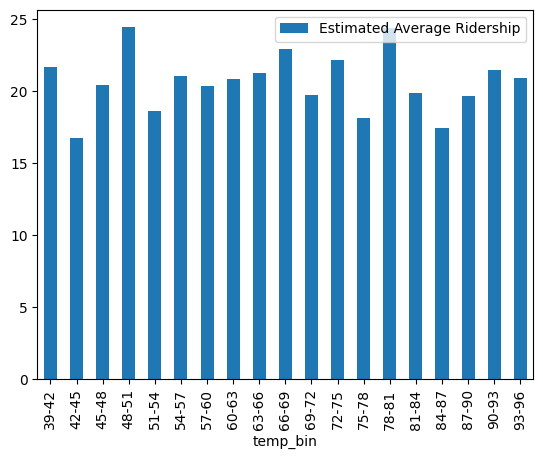

In [246]:
ridership_by_temp_bin.plot(kind="bar", x="temp_bin")

In [253]:
bins = [i * 0.2 for i in range(101)]
labels = [f"{round(bins[i], 1)}-{round(bins[i+1], 1)}" for i in range(len(bins)-1)]

# Bin the maximum temperatures
daily_total_percip['percip_bin'] = pd.cut(daily_total_percip['precipitation (inch)'], bins=bins, labels=labels, right=False)

# Merge ridership with temperature data
merged_data = pd.merge(daily_ridership, daily_total_percip, on='date')

# Aggregate ridership by temperature bins
ridership_by_percip_bin = merged_data.groupby('percip_bin', observed=True)['Estimated Average Ridership'].mean().reset_index().dropna()

print(ridership_by_percip_bin)

  percip_bin  Estimated Average Ridership
0    0.0-0.2                    20.152262
1    0.2-0.4                    20.438921
2    0.4-0.6                    22.848663
3    0.6-0.8                    24.823692
4    0.8-1.0                    17.559586
5    1.0-1.2                    17.223147
6    1.2-1.4                    23.350349
7    1.4-1.6                    23.210414


In [254]:
# Percip does not really have an effect overall?
# Let's check Friday/Weekend nights

In [255]:
daily_weather_summaries

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code),date
0,2024-01-01T00:00,34.9,74,28.8,0.0,3,2024-01-01
1,2024-01-01T01:00,34.8,76,28.1,0.0,3,2024-01-01
2,2024-01-01T02:00,36.6,74,29.4,0.0,3,2024-01-01
3,2024-01-01T03:00,36.8,74,30.1,0.0,3,2024-01-01
4,2024-01-01T04:00,36.5,76,30.2,0.0,2,2024-01-01
...,...,...,...,...,...,...,...
6595,2024-10-01T19:00,63.6,75,62.4,0.0,0,2024-10-01
6596,2024-10-01T20:00,61.3,83,60.9,0.0,0,2024-10-01
6597,2024-10-01T21:00,59.0,88,58.5,0.0,0,2024-10-01
6598,2024-10-01T22:00,59.0,88,58.7,0.0,1,2024-10-01


In [258]:
daily_weather_summaries.head(14)

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code),date
0,2024-01-01T00:00,34.9,74,28.8,0.0,3,2024-01-01
1,2024-01-01T01:00,34.8,76,28.1,0.0,3,2024-01-01
2,2024-01-01T02:00,36.6,74,29.4,0.0,3,2024-01-01
3,2024-01-01T03:00,36.8,74,30.1,0.0,3,2024-01-01
4,2024-01-01T04:00,36.5,76,30.2,0.0,2,2024-01-01
5,2024-01-01T05:00,32.9,88,26.7,0.0,2,2024-01-01
6,2024-01-01T06:00,32.0,91,25.5,0.0,3,2024-01-01
7,2024-01-01T07:00,34.2,88,29.3,0.0,3,2024-01-01
8,2024-01-01T08:00,35.0,86,29.7,0.0,3,2024-01-01
9,2024-01-01T09:00,37.4,81,32.4,0.0,3,2024-01-01


In [265]:
import pandas as pd

# Assuming daily_weather_summaries is already loaded

# Convert time to datetime
daily_weather_summaries['datetime'] = pd.to_datetime(daily_weather_summaries['time'])

# Filter for Friday 9 PM to Saturday 4 AM
friday_night_data = daily_weather_summaries[
    ((daily_weather_summaries['datetime'].dt.weekday == 4) & (daily_weather_summaries['datetime'].dt.hour >= 21)) |
    ((daily_weather_summaries['datetime'].dt.weekday == 5) & (daily_weather_summaries['datetime'].dt.hour < 4))
]

# Group by date (using Friday's date)
friday_night_grouped = friday_night_data.groupby(friday_night_data['datetime'].dt.date)

# Aggregate max temp, min temp, and total precipitation
friday_night_summary = friday_night_grouped.agg({
    'temperature_2m (°F)': ['max', 'min'],
    'precipitation (inch)': 'sum'
}).reset_index()

friday_night_summary.columns = ['Date', 'max_temp', 'min_temp', 'total_precip']
friday_night_summary

,Date,max_temp,min_temp,total_precip
0,2024-01-05,29.8,27.0,0.000
1,2024-01-06,25.7,23.7,0.000
2,2024-01-12,43.7,42.8,0.032
3,2024-01-13,50.1,44.6,0.603
4,2024-01-19,24.5,23.4,0.000
...,...,...,...,...
73,2024-09-14,64.4,60.4,0.000
74,2024-09-20,69.1,66.5,0.000
75,2024-09-21,64.7,61.1,0.000
76,2024-09-27,65.9,65.2,0.020


In [267]:
merged_data = pd.merge(friday_nights_ridership, friday_night_summary, on="Date")

In [269]:
merged_data.head()

,Date,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership,max_temp,min_temp,total_precip
0,2024-01-12,1,2,3.099833,43.7,42.8,0.032
1,2024-01-12,1,3,5.797167,43.7,42.8,0.032
2,2024-01-12,1,4,5.800333,43.7,42.8,0.032
3,2024-01-12,1,5,2.924433,43.7,42.8,0.032
4,2024-01-12,1,6,3.414333,43.7,42.8,0.032


In [278]:
bad_weather = (
    (merged_data['total_precip'] > 0.5) |
    (merged_data['min_temp'] < 50)
)
print(merged_data["Estimated Average Ridership"].mean(), merged_data[bad_weather]["Estimated Average Ridership"].mean())

1.0548421930438594 1.0405258536564324


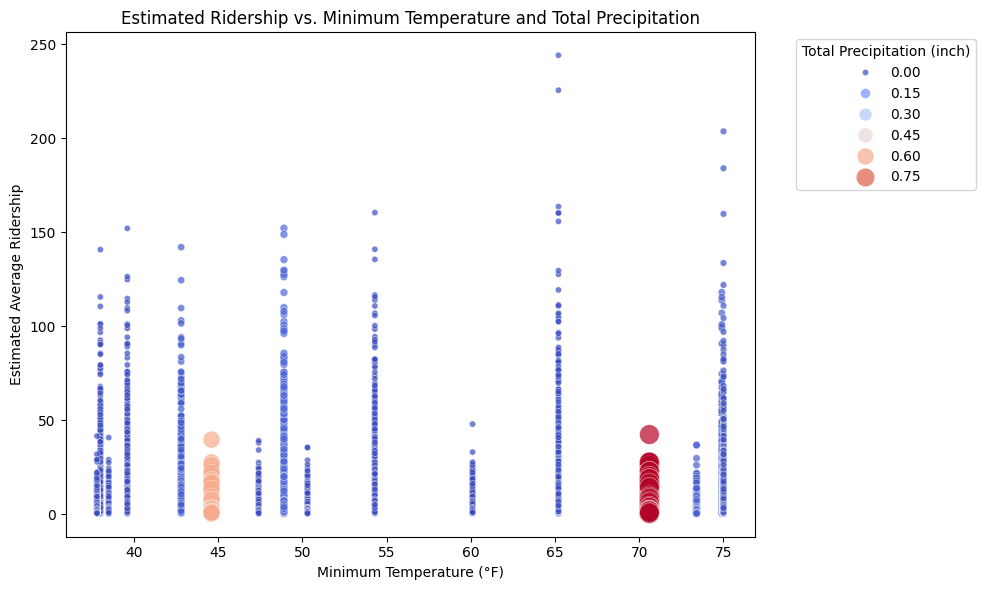

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

bad_weather = (
    (merged_data['total_precip'] > 0.5) |
    (merged_data['min_temp'] < 50)
)
print(merged_data["Estimated Average Ridership"].mean(), merged_data[bad_weather]["Estimated Average Ridership"].mean())

# Assuming merged_data is already loaded

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='min_temp',
    y='Estimated Average Ridership',
    size='total_precip',
    hue='total_precip',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7
)

# Add labels and title
plt.title('Estimated Ridership vs. Minimum Temperature and Total Precipitation')
plt.xlabel('Minimum Temperature (°F)')
plt.ylabel('Estimated Average Ridership')
plt.legend(title='Total Precipitation (inch)', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


In [22]:
# Beach (The Rockaways and Coney Island)
coney_island = ((stations["ntaname"].str.contains("Coney Island")) | (stations["ntaname"].str.contains("Brighton Beach")))
the_rockaways = (stations["ntaname"].str.contains("Rockaway") | stations["ntaname"].str.contains("Hammels"))

popular_beach_stations = stations[coney_island | the_rockaways]

popular_beach_stations

,GTFS Stop ID,Station ID,Complex ID,Line,Stop Name,boro_name,ntaname
54,D40,55,55,Broadway - Brighton,Brighton Beach,Brooklyn,Brighton Beach
55,D41,56,56,Broadway - Brighton,Ocean Pkwy,Brooklyn,Brighton Beach
199,H04,199,199,Rockaway,Broad Channel,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
200,H12,200,200,Rockaway,Beach 90 St,Queens,Hammels-Arverne-Edgemere
201,H13,201,201,Rockaway,Beach 98 St,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
202,H14,202,202,Rockaway,Beach 105 St,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
203,H15,203,203,Rockaway,Rockaway Park-Beach 116 St,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
204,H06,204,204,Rockaway,Beach 67 St,Queens,Hammels-Arverne-Edgemere
205,H07,205,205,Rockaway,Beach 60 St,Queens,Hammels-Arverne-Edgemere
206,H08,206,206,Rockaway,Beach 44 St,Queens,Hammels-Arverne-Edgemere


In [40]:
import pandas as pd

def join_chunk_by_ntanames(chunk, stations, ntanames, is_origin):
    # Filter stations by ntanames
    relevant_stations = stations[stations['ntaname'].isin(ntanames)]
    relevant_ids = relevant_stations['Complex ID'].unique()

    # Filter chunk for relevant origin or destination stations
    if is_origin:
        filtered_chunk = chunk[
            chunk['Origin Station Complex ID'].isin(relevant_ids)
        ]
    else:
        filtered_chunk = chunk[
            chunk['Destination Station Complex ID'].isin(relevant_ids)
        ]

    return filtered_chunk

def process_large_csv_with_ntanames(stations, ntanames, file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000, is_origin=True):
    results = []
    cols = [
        'Day of Week', 'Timestamp', 'Origin Station Complex ID', 'Origin Station Complex Name', 
        'Destination Station Complex ID', 'Destination Station Complex Name',
        'Estimated Average Ridership'
    ]
    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        processed_chunk = join_chunk_by_ntanames(chunk, stations, ntanames, is_origin)
        results.append(processed_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)
    final_result["Timestamp"] = pd.to_datetime(final_result['Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
    return final_result

select_by_ntanames = lambda ntanames, is_origin=False: process_large_csv_with_ntanames(
    stations, ntanames, is_origin=is_origin
)

In [377]:
beach_neighborhoods = popular_beach_stations["ntaname"].unique()
A = select_by_ntanames(beach_neighborhoods)

In [381]:
A[A["Timestamp"] == pd.Timestamp("2024-01-12")]

,Day of Week,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Destination Station Complex ID,Destination Station Complex Name,Estimated Average Ridership
2099,Friday,2024-01-12,611,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",208,Beach 25 St (A),0.9772
2100,Friday,2024-01-12,624,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",204,Beach 67 St (A),1.1788
2101,Friday,2024-01-12,608,"4 Av (F,G)/9 St (R)",56,Ocean Pkwy (Q),0.6000
2102,Friday,2024-01-12,68,Bay Pkwy (D),56,Ocean Pkwy (Q),0.2918
2103,Friday,2024-01-12,70,Bay 50 St (D),56,Ocean Pkwy (Q),0.2500
...,...,...,...,...,...,...,...
2360,Friday,2024-01-12,107,"Broad St (J,Z)",208,Beach 25 St (A),0.7972
2361,Friday,2024-01-12,20,"City Hall (R,W)",56,Ocean Pkwy (Q),0.3000
2362,Friday,2024-01-12,312,79 St (1),55,"Brighton Beach (B,Q)",0.2657
2363,Friday,2024-01-12,186,Van Siclen Av (C),209,Far Rockaway-Mott Av (A),0.3500


In [35]:
weather_summary = pd.read_csv("open-meteo-40.74N74.04W51m.csv", skiprows=2)

In [36]:
weather_summary

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code)
0,2024-01-01T00:00,34.9,74,28.8,0.0,3
1,2024-01-01T01:00,34.8,76,28.1,0.0,3
2,2024-01-01T02:00,36.6,74,29.4,0.0,3
3,2024-01-01T03:00,36.8,74,30.1,0.0,3
4,2024-01-01T04:00,36.5,76,30.2,0.0,2
...,...,...,...,...,...,...
6595,2024-10-01T19:00,63.6,75,62.4,0.0,0
6596,2024-10-01T20:00,61.3,83,60.9,0.0,0
6597,2024-10-01T21:00,59.0,88,58.5,0.0,0
6598,2024-10-01T22:00,59.0,88,58.7,0.0,1


In [389]:
S.sort_values(by="Timestamp").head()

,Day of Week,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Destination Station Complex ID,Destination Station Complex Name,Estimated Average Ridership
286579,Monday,2024-01-08,55,"Brighton Beach (B,Q)",46,Cortelyou Rd (Q),0.6166
286557,Monday,2024-01-08,55,"Brighton Beach (B,Q)",350,Pennsylvania Av (3),0.2740
286556,Monday,2024-01-08,55,"Brighton Beach (B,Q)",77,Kings Hwy (N),0.2740
286555,Monday,2024-01-08,55,"Brighton Beach (B,Q)",609,"Bryant Pk (B,D,F,M)/5 Av (7)",0.2666
286554,Monday,2024-01-08,55,"Brighton Beach (B,Q)",64,71 St (D),0.2740


In [373]:
merged_df["Timestamp"]

0        2024-01-12 10:00:00
1        2024-01-12 10:00:00
2        2024-01-12 10:00:00
3        2024-01-12 10:00:00
4        2024-01-12 10:00:00
                 ...        
969141   2024-01-12 10:00:00
969142   2024-01-12 10:00:00
969143   2024-01-12 10:00:00
969144   2024-01-12 10:00:00
969145   2024-01-12 10:00:00
Name: Timestamp, Length: 969146, dtype: datetime64[ns]

In [374]:
A["Timestamp"]

0        2024-01-12 10:00:00
1        2024-01-12 10:00:00
2        2024-01-12 10:00:00
3        2024-01-12 10:00:00
4        2024-01-12 10:00:00
                 ...        
969141   2024-01-12 10:00:00
969142   2024-01-12 10:00:00
969143   2024-01-12 10:00:00
969144   2024-01-12 10:00:00
969145   2024-01-12 10:00:00
Name: Timestamp, Length: 969146, dtype: datetime64[ns]

In [4]:
A = pd.read_csv("MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=10000)
A = next(A)

In [5]:
A.head()

,Year,Month,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Origin Latitude,Origin Longitude,Destination Station Complex ID,Destination Station Complex Name,Destination Latitude,Destination Longitude,Estimated Average Ridership,Origin Point,Destination Point
0,2024,1,Friday,10,01/12/2024 10:00:00 AM,99,"Lorimer St (M,J)",40.703869,-73.947408,84,85 St-Forest Pkwy (J),40.692435,-73.860010,0.3075,POINT (-73.947408 40.703869),POINT (-73.86001 40.692435)
1,2024,1,Friday,10,01/12/2024 10:00:00 AM,198,Howard Beach-JFK Airport (A),40.660476,-73.830301,190,80 St (A),40.679371,-73.858992,2.0995,POINT (-73.830301 40.660476),POINT (-73.858992 40.679371)
2,2024,1,Friday,10,01/12/2024 10:00:00 AM,213,"Fordham Rd (B,D)",40.861296,-73.897749,320,23 St (1),40.744081,-73.995657,0.3007,POINT (-73.897749 40.861296),POINT (-73.995657 40.744081)
3,2024,1,Friday,10,01/12/2024 10:00:00 AM,421,"Gun Hill Rd (2,5)",40.877850,-73.866256,122,Graham Av (L),40.714565,-73.944053,0.3575,POINT (-73.866256 40.87785),POINT (-73.944053 40.714565)
4,2024,1,Friday,10,01/12/2024 10:00:00 AM,442,Eastchester-Dyre Av (5),40.888300,-73.830834,87,"Crescent St (J,Z)",40.683194,-73.873785,0.3288,POINT (-73.830834 40.8883),POINT (-73.873785 40.683194)


In [6]:
A.sort_values(by="Timestamp")

,Year,Month,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Origin Latitude,Origin Longitude,Destination Station Complex ID,Destination Station Complex Name,Destination Latitude,Destination Longitude,Estimated Average Ridership,Origin Point,Destination Point
0,2024,1,Friday,10,01/12/2024 10:00:00 AM,99,"Lorimer St (M,J)",40.703869,-73.947408,84,85 St-Forest Pkwy (J),40.692435,-73.860010,0.3075,POINT (-73.947408 40.703869),POINT (-73.86001 40.692435)
6660,2024,1,Friday,10,01/12/2024 10:00:00 AM,261,"Forest Hills-71 Av (E,F,M,R)",40.721691,-73.844521,75,20 Av (N),40.617410,-73.985026,0.2928,POINT (-73.844521 40.721691),POINT (-73.985026 40.61741)
6661,2024,1,Friday,10,01/12/2024 10:00:00 AM,619,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",40.725606,-73.995432,328,WTC Cortlandt (1),40.711835,-74.012188,1.8770,POINT (-73.995432 40.725606),POINT (-74.012188 40.711835)
6662,2024,1,Friday,10,01/12/2024 10:00:00 AM,66,18 Av (D),40.607954,-74.001736,346,Sutter Av-Rutland Rd (3),40.664717,-73.922610,0.3110,POINT (-74.001736 40.607954),POINT (-73.92261 40.664717)
6663,2024,1,Friday,10,01/12/2024 10:00:00 AM,189,Grant Av (A),40.677044,-73.865050,127,DeKalb Av (L),40.703811,-73.918425,0.3462,POINT (-73.86505 40.677044),POINT (-73.918425 40.703811)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2024,6,Saturday,14,06/08/2024 02:00:00 PM,369,Elder Av (6),40.828584,-73.879159,388,167 St (4),40.835537,-73.921400,0.4802,POINT (-73.879159 40.828584),POINT (-73.9214 40.835537)
6689,2024,6,Saturday,14,06/08/2024 02:00:00 PM,74,18 Av (N),40.620671,-73.990414,70,Bay 50 St (D),40.588841,-73.983765,0.5454,POINT (-73.990414 40.620671),POINT (-73.983765 40.588841)
4776,2024,6,Saturday,14,06/08/2024 02:00:00 PM,369,Elder Av (6),40.828584,-73.879159,395,103 St (6),40.790600,-73.947478,0.9824,POINT (-73.879159 40.828584),POINT (-73.947478 40.7906)
1581,2024,6,Saturday,14,06/08/2024 02:00:00 PM,383,183 St (4),40.858407,-73.903879,385,176 St (4),40.848480,-73.911794,1.3588,POINT (-73.903879 40.858407),POINT (-73.911794 40.84848)


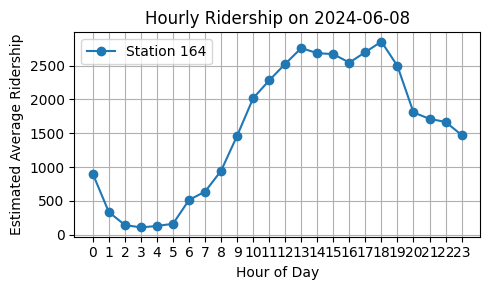

In [16]:
plot_ridership_for_stations([164], "2024-06-08")

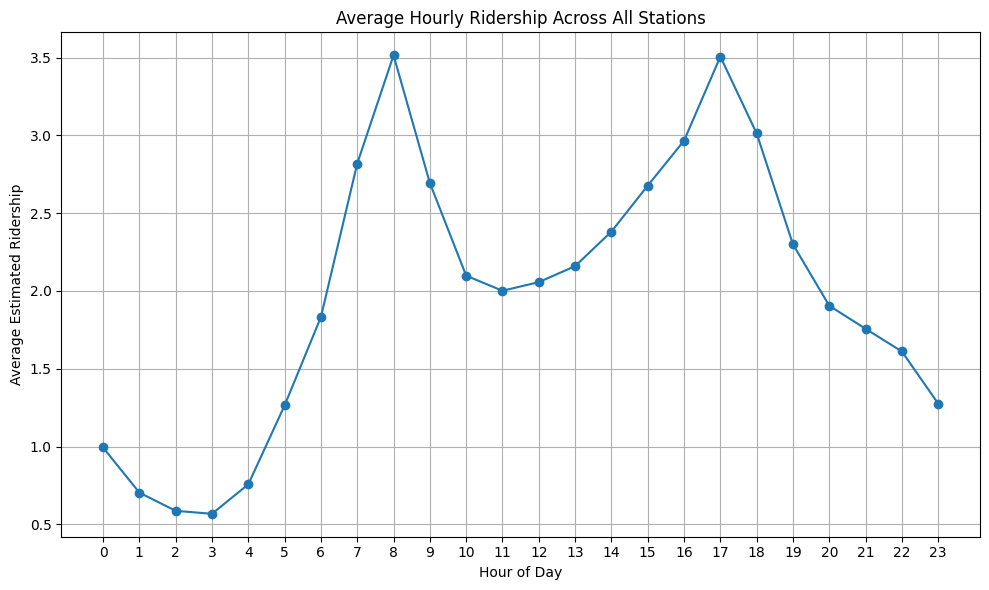

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_ridership_by_hour(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = ['Hour of Day', 'Estimated Average Ridership']

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        results.append(chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and calculate the average ridership
    hourly_avg_ridership = final_result.groupby('Hour of Day')['Estimated Average Ridership'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_avg_ridership['Hour of Day'], hourly_avg_ridership['Estimated Average Ridership'], marker='o')
    plt.xticks(hourly_avg_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Estimated Ridership')
    plt.title('Average Hourly Ridership Across All Stations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_ridership_by_hour()

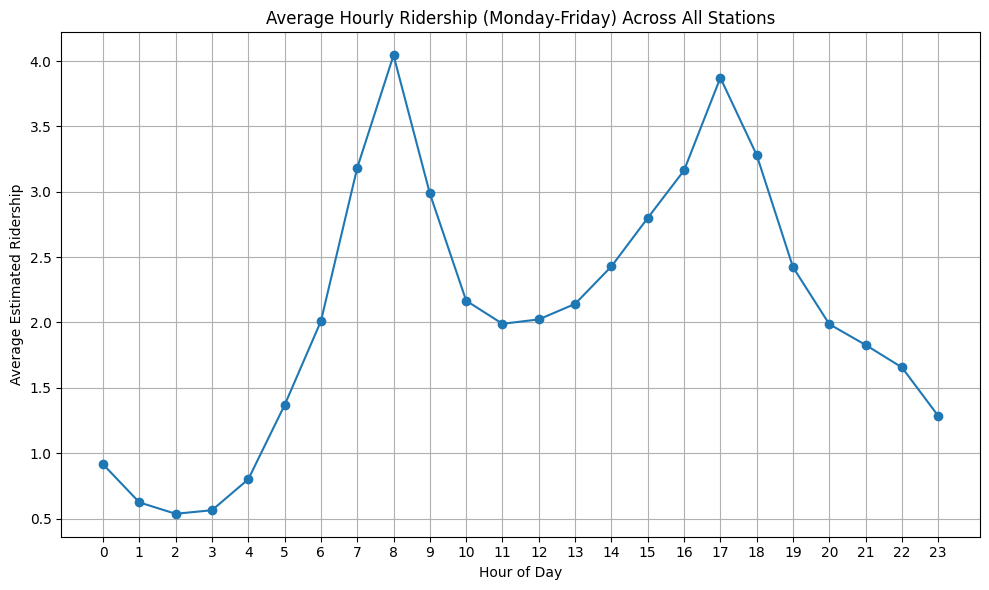

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_ridership_weekdays(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = ['Hour of Day', 'Estimated Average Ridership', 'Day of Week']

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        # Filter for weekdays (Monday to Friday)
        weekdays_chunk = chunk[chunk['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
        results.append(weekdays_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and calculate the average ridership
    hourly_avg_ridership = final_result.groupby('Hour of Day')['Estimated Average Ridership'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_avg_ridership['Hour of Day'], hourly_avg_ridership['Estimated Average Ridership'], marker='o')
    plt.xticks(hourly_avg_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Estimated Ridership')
    plt.title('Average Hourly Ridership (Monday-Friday) Across All Stations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_ridership_weekdays()

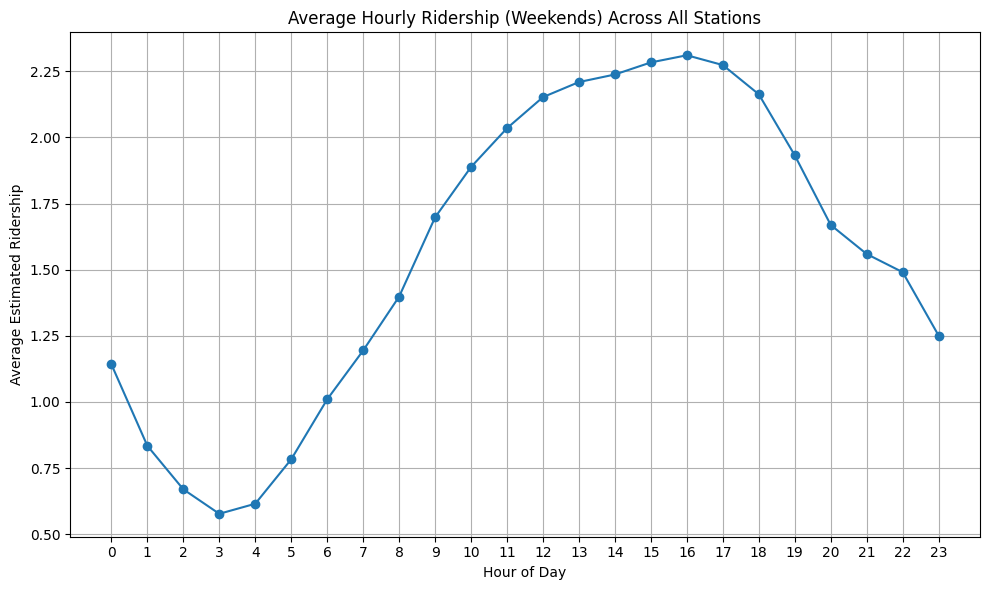

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_ridership_weekdends(file_path="MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241017.csv", chunksize=100000):
    results = []
    cols = ['Hour of Day', 'Estimated Average Ridership', 'Day of Week']

    for chunk in pd.read_csv(file_path, usecols=cols, chunksize=chunksize):
        # Filter for weekdays (Monday to Friday)
        weekdays_chunk = chunk[chunk['Day of Week'].isin(['Saturday', 'Sunday'])]
        results.append(weekdays_chunk)

    # Concatenate all results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)

    # Group by hour and calculate the average ridership
    hourly_avg_ridership = final_result.groupby('Hour of Day')['Estimated Average Ridership'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_avg_ridership['Hour of Day'], hourly_avg_ridership['Estimated Average Ridership'], marker='o')
    plt.xticks(hourly_avg_ridership['Hour of Day'].unique())
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Estimated Ridership')
    plt.title('Average Hourly Ridership (Weekends) Across All Stations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_ridership_weekdends()

In [29]:
popular_beach_stations

,GTFS Stop ID,Station ID,Complex ID,Line,Stop Name,boro_name,ntaname
54,D40,55,55,Broadway - Brighton,Brighton Beach,Brooklyn,Brighton Beach
55,D41,56,56,Broadway - Brighton,Ocean Pkwy,Brooklyn,Brighton Beach
199,H04,199,199,Rockaway,Broad Channel,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
200,H12,200,200,Rockaway,Beach 90 St,Queens,Hammels-Arverne-Edgemere
201,H13,201,201,Rockaway,Beach 98 St,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
202,H14,202,202,Rockaway,Beach 105 St,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
203,H15,203,203,Rockaway,Rockaway Park-Beach 116 St,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...
204,H06,204,204,Rockaway,Beach 67 St,Queens,Hammels-Arverne-Edgemere
205,H07,205,205,Rockaway,Beach 60 St,Queens,Hammels-Arverne-Edgemere
206,H08,206,206,Rockaway,Beach 44 St,Queens,Hammels-Arverne-Edgemere


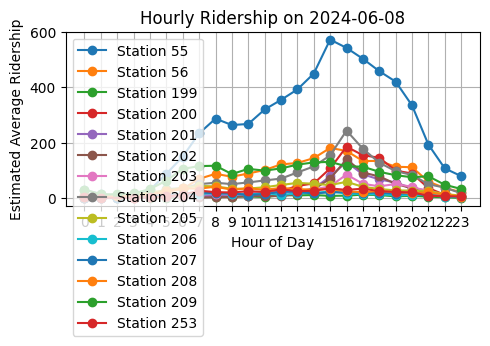

In [33]:
plot_ridership_for_stations(popular_beach_stations["Complex ID"].unique(), "2024-06-08")

In [37]:
weather_summary

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code)
0,2024-01-01T00:00,34.9,74,28.8,0.0,3
1,2024-01-01T01:00,34.8,76,28.1,0.0,3
2,2024-01-01T02:00,36.6,74,29.4,0.0,3
3,2024-01-01T03:00,36.8,74,30.1,0.0,3
4,2024-01-01T04:00,36.5,76,30.2,0.0,2
...,...,...,...,...,...,...
6595,2024-10-01T19:00,63.6,75,62.4,0.0,0
6596,2024-10-01T20:00,61.3,83,60.9,0.0,0
6597,2024-10-01T21:00,59.0,88,58.5,0.0,0
6598,2024-10-01T22:00,59.0,88,58.7,0.0,1


In [41]:
select_by_ntan

In [42]:
beach_neighborhood_ridership

,Day of Week,Timestamp,Origin Station Complex ID,Origin Station Complex Name,Destination Station Complex ID,Destination Station Complex Name,Estimated Average Ridership
0,Friday,2024-01-12 10:00:00,628,"Fulton St (A,C,J,Z,2,3,4,5)",209,Far Rockaway-Mott Av (A),0.3260
1,Friday,2024-01-12 10:00:00,209,Far Rockaway-Mott Av (A),56,Ocean Pkwy (Q),0.3918
2,Friday,2024-01-12 10:00:00,155,"Cathedral Pkwy (110 St) (C,B)",204,Beach 67 St (A),0.2975
3,Friday,2024-01-12 10:00:00,223,"Lexington Av/63 St (F,Q)",55,"Brighton Beach (B,Q)",1.5980
4,Friday,2024-01-12 10:00:00,394,110 St (6),205,Beach 60 St (A),0.3147
...,...,...,...,...,...,...,...
969141,Friday,2024-01-12 10:00:00,138,Canarsie-Rockaway Pkwy (L),207,Beach 36 St (A),0.3425
969142,Friday,2024-01-12 10:00:00,284,Nassau Av (G),209,Far Rockaway-Mott Av (A),0.2500
969143,Friday,2024-01-12 10:00:00,610,"Grand Central-42 St (S,4,5,6,7)",207,Beach 36 St (A),0.3190
969144,Friday,2024-01-12 10:00:00,78,Avenue U (N),55,"Brighton Beach (B,Q)",0.3232


/var/folders/2z/znp5mbz57px8r00d9z3br30w0000gn/T/ipykernel_55999/1693693595.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


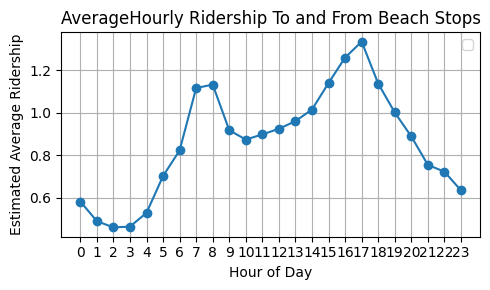

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

results = []
cols = [
    'Timestamp', 'Origin Station Complex ID', 'Destination Station Complex ID',
    'Estimated Average Ridership', 'Hour of Day'
]

beach_neighborhood_ridership['Timestamp'] = pd.to_datetime(beach_neighborhood_ridership['Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
beach_neighborhood_ridership["Hour of Day"] = beach_neighborhood_ridership["Timestamp"].dt.hour

beach_hourly_ridership = beach_neighborhood_ridership.groupby(['Hour of Day'])['Estimated Average Ridership'].mean().reset_index()

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(beach_hourly_ridership['Hour of Day'], beach_hourly_ridership['Estimated Average Ridership'], marker='o')

plt.xticks(beach_hourly_ridership['Hour of Day'].unique())
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Ridership')
plt.title(f'Average Hourly Ridership To and From Beach Stops')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
beach_station_ids = beach_neighborhood_ridership["Origin Station Complex ID"].unique()

In [127]:
daily_beach_destinations = daily_ridership[daily_ridership["Origin Station Complex ID"].isin(beach_station_ids)]
daily_beach_destinations["date"] = daily_beach_destinations["Date"]

In [128]:
daily_beach_destinations["date"] = pd.to_datetime(daily_beach_destinations["date"])

In [129]:
daily_max_temp["date"] = pd.to_datetime(daily_max_temp["date"])

In [130]:
m = pd.merge(daily_beach_destinations, daily_max_temp, on="date")

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code),Date
0,2024-01-01 00:00:00,34.9,74,28.8,0.0,3,2024-01-01
1,2024-01-01 01:00:00,34.8,76,28.1,0.0,3,2024-01-01
2,2024-01-01 02:00:00,36.6,74,29.4,0.0,3,2024-01-01
3,2024-01-01 03:00:00,36.8,74,30.1,0.0,3,2024-01-01
4,2024-01-01 04:00:00,36.5,76,30.2,0.0,2,2024-01-01
...,...,...,...,...,...,...,...
6595,2024-10-01 19:00:00,63.6,75,62.4,0.0,0,2024-10-01
6596,2024-10-01 20:00:00,61.3,83,60.9,0.0,0,2024-10-01
6597,2024-10-01 21:00:00,59.0,88,58.5,0.0,0,2024-10-01
6598,2024-10-01 22:00:00,59.0,88,58.7,0.0,1,2024-10-01


/var/folders/2z/znp5mbz57px8r00d9z3br30w0000gn/T/ipykernel_55999/682730634.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridership_filtered['Hour of Day'] = ridership_filtered['Timestamp'].dt.hour
/var/folders/2z/znp5mbz57px8r00d9z3br30w0000gn/T/ipykernel_55999/682730634.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_filtered['Hour of Day'] = weather_filtered['time'].dt.hour


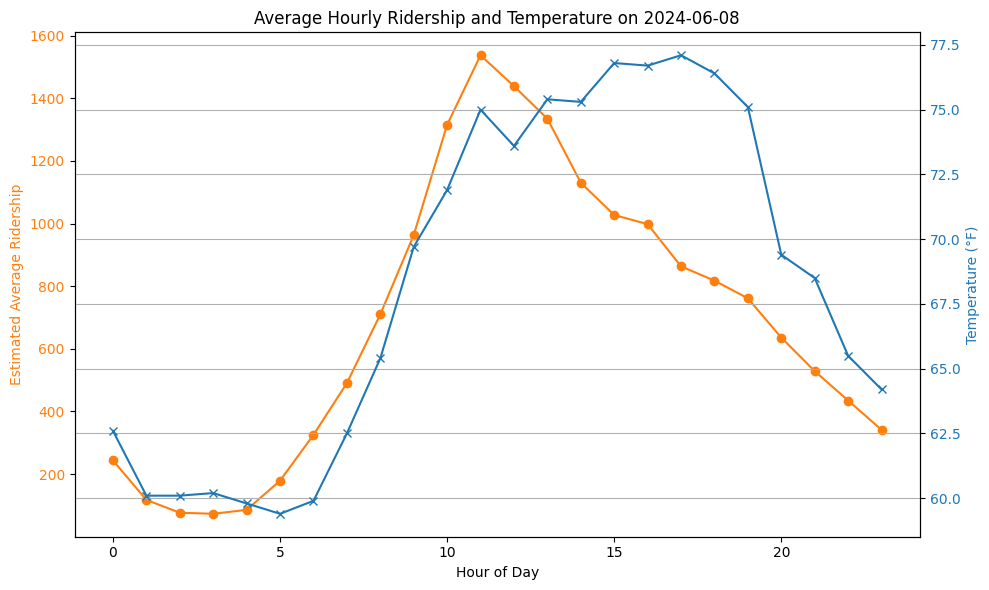

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ridership_and_temperature_for_date(date_str, beach_neighborhood_ridership, weather_summary):
    # Convert date string to datetime
    target_date = pd.to_datetime(date_str).date()

    # Filter ridership data for the specific date
    beach_neighborhood_ridership['Date'] = beach_neighborhood_ridership['Timestamp'].dt.date
    ridership_filtered = beach_neighborhood_ridership[beach_neighborhood_ridership['Date'] == target_date]
    ridership_filtered['Hour of Day'] = ridership_filtered['Timestamp'].dt.hour
    beach_hourly_ridership = ridership_filtered.groupby('Hour of Day')['Estimated Average Ridership'].sum().reset_index()

    # Filter weather data for the specific date
    weather_summary['Date'] = weather_summary['time'].dt.date
    weather_filtered = weather_summary[weather_summary['Date'] == target_date]
    weather_filtered['Hour of Day'] = weather_filtered['time'].dt.hour
    hourly_temperature = weather_filtered.groupby('Hour of Day')['temperature_2m (°F)'].mean().reset_index()

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot ridership
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Estimated Average Ridership', color='tab:orange')
    ax1.plot(beach_hourly_ridership['Hour of Day'], beach_hourly_ridership['Estimated Average Ridership'], marker='o', color='tab:orange', label='Ridership')
    ax1.tick_params(axis='y', labelcolor='tab:orange')

    # Create a second y-axis for temperature
    ax2 = ax1.twinx()
    ax2.set_ylabel('Temperature (°F)', color='tab:blue')
    ax2.plot(hourly_temperature['Hour of Day'], hourly_temperature['temperature_2m (°F)'], marker='x', color='tab:blue', label='Temperature')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Title and layout
    plt.title(f'Average Hourly Ridership and Temperature on {date_str}')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

# Example usage
plot_ridership_and_temperature_for_date('2024-06-08', beach_neighborhood_ridership, weather_summary)

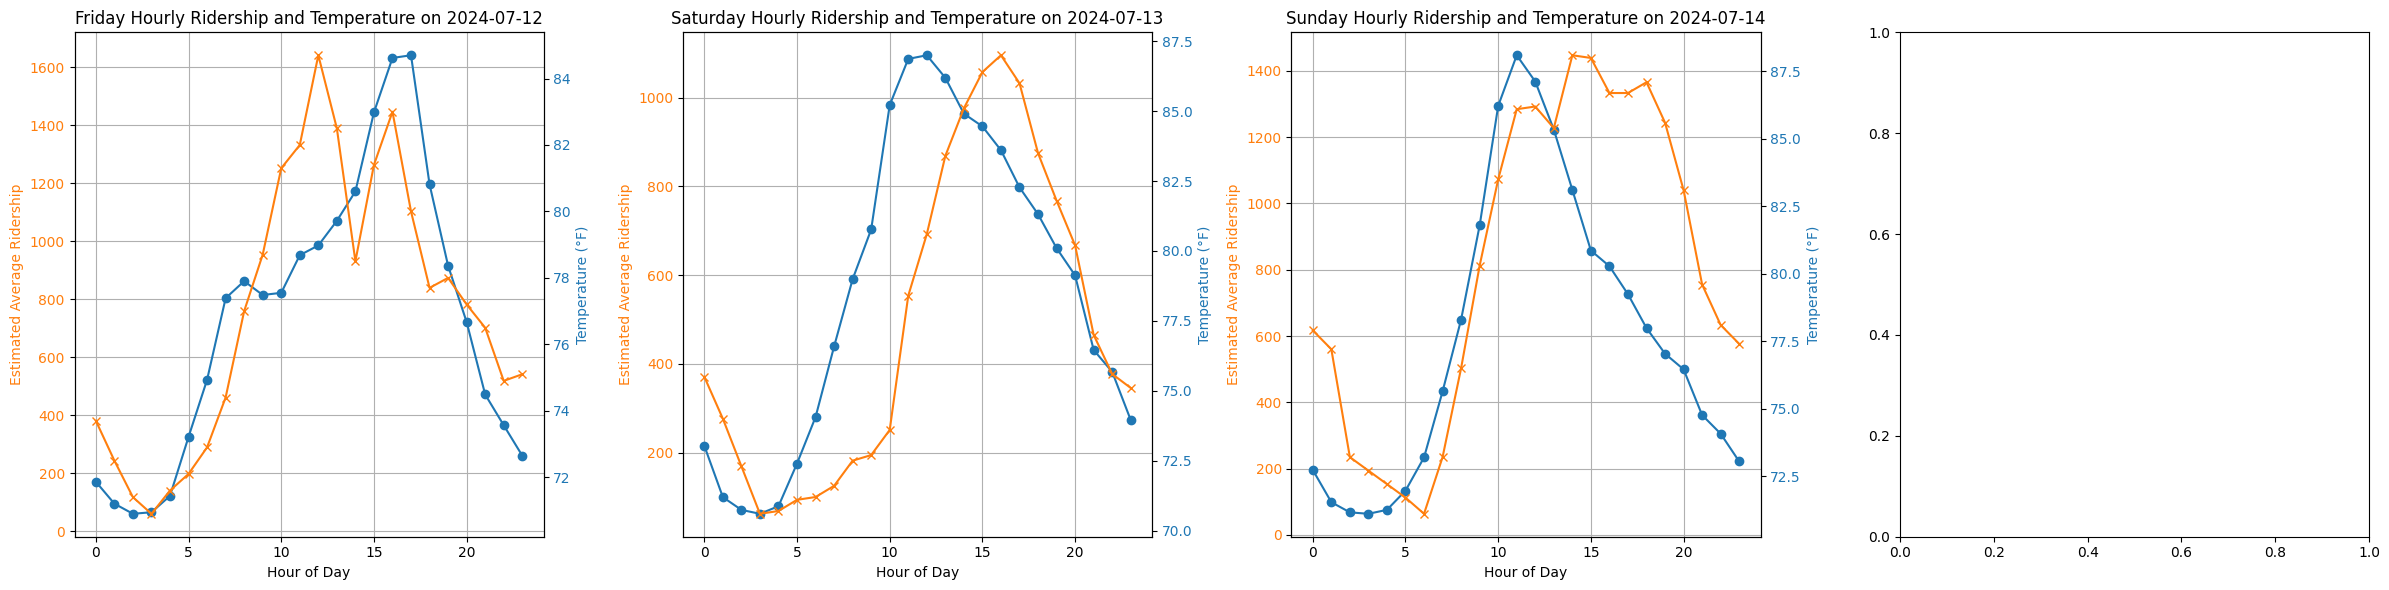

In [215]:
import pandas as pd
import matplotlib.pyplot as plt

def get_day_of_week_name(date):
    return date.strftime("%A")

def plot_ridership_and_temperature_for_dates(dates, beach_neighborhood_ridership, weather_summary):
    num_dates = len(dates)
    cols = num_dates  # Number of columns in the grid
    rows = 1  # Single row

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6))
    if num_dates == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    # Ensure 'Date' column is calculated once outside the loop
    beach_neighborhood_ridership['Date'] = beach_neighborhood_ridership['Timestamp'].dt.date
    weather_summary['Date'] = weather_summary['time'].dt.date

    plot_index = 0  # Track the index for plotting

    for date_str in dates:
        target_date = pd.to_datetime(date_str).date()

        # Filter ridership data for the specific date
        ridership_filtered = beach_neighborhood_ridership[beach_neighborhood_ridership['Date'] == target_date].copy()
        weather_filtered = weather_summary[weather_summary['Date'] == target_date].copy()
        dow = get_day_of_week_name(target_date)

        # Skip plotting if either filtered DataFrame is empty
        if ridership_filtered.empty or weather_filtered.empty:
            continue

        ridership_filtered.loc[:, 'Hour of Day'] = ridership_filtered['Timestamp'].dt.hour
        beach_hourly_ridership = ridership_filtered.groupby('Hour of Day')['Estimated Average Ridership'].sum().reset_index()

        weather_filtered.loc[:, 'Hour of Day'] = weather_filtered['time'].dt.hour
        hourly_temperature = weather_filtered.groupby('Hour of Day')['temperature_2m (°F)'].mean().reset_index()

        ax1 = axes[plot_index]

        # Plot ridership
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Estimated Average Ridership', color='tab:orange')
        ax1.plot(beach_hourly_ridership['Hour of Day'], beach_hourly_ridership['Estimated Average Ridership'], marker='o', color='tab:blue', label='Ridership')
        ax1.tick_params(axis='y', labelcolor='tab:orange')

        # Create a second y-axis for temperature
        ax2 = ax1.twinx()
        ax2.set_ylabel('Temperature (°F)', color='tab:blue')
        ax2.plot(hourly_temperature['Hour of Day'], hourly_temperature['temperature_2m (°F)'], marker='x', color='tab:orange', label='Temperature')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        ax1.set_title(f'{dow} Hourly Ridership and Temperature on {date_str}')
        ax1.grid(True)

        plot_index += 1  # Increment plot index only if a plot was made

    # Adjust layout
    fig.tight_layout()
    plt.show()

plot_ridership_and_temperature_for_dates(['2024-07-01', '2024-07-12', '2024-07-13', '2024-07-14'], beach_neighborhood_ridership, weather_summary)


In [216]:
weather_summary

,time,temperature_2m (°F),relative_humidity_2m (%),apparent_temperature (°F),precipitation (inch),weather_code (wmo code),Date,Hour of Day
0,2024-01-01 00:00:00,34.9,74,28.8,0.0,3,2024-01-01,0
1,2024-01-01 01:00:00,34.8,76,28.1,0.0,3,2024-01-01,1
2,2024-01-01 02:00:00,36.6,74,29.4,0.0,3,2024-01-01,2
3,2024-01-01 03:00:00,36.8,74,30.1,0.0,3,2024-01-01,3
4,2024-01-01 04:00:00,36.5,76,30.2,0.0,2,2024-01-01,4
...,...,...,...,...,...,...,...,...
6595,2024-10-01 19:00:00,63.6,75,62.4,0.0,0,2024-10-01,19
6596,2024-10-01 20:00:00,61.3,83,60.9,0.0,0,2024-10-01,20
6597,2024-10-01 21:00:00,59.0,88,58.5,0.0,0,2024-10-01,21
6598,2024-10-01 22:00:00,59.0,88,58.7,0.0,1,2024-10-01,22


In [197]:
def find_high_temp_weekends(weather_summary, threshold):
    # Ensure the DataFrame is sorted by date
    weather_summary = weather_summary.sort_values(by='Date')

    # Calculate daily max temperature
    daily_max_temp = weather_summary.groupby('Date')['temperature_2m (°F)'].max().reset_index()
    daily_max_temp['Day of Week'] = pd.to_datetime(daily_max_temp['Date']).dt.day_name()

    # List to store windows of high temperature weekends
    high_temp_weekends = []

    # Iterate over the daily max temperature DataFrame
    for i in range(len(daily_max_temp)):
        day_of_week = daily_max_temp.iloc[i]['Day of Week']

        # Check if the current day is Saturday or Sunday and above the threshold
        if day_of_week in ['Saturday', 'Sunday'] and daily_max_temp.iloc[i]['temperature_2m (°F)'] > threshold:
            # Find the index for the Thursday of the same week
            thursday_index = i - (pd.to_datetime(daily_max_temp.iloc[i]['Date']).weekday() - 3)
            # Define the window range from Thursday to Monday
            start = max(0, thursday_index)
            end = min(len(daily_max_temp), thursday_index + 5)

            # Extract the window of dates
            window_dates = daily_max_temp.iloc[start:end]['Date'].tolist()
            high_temp_weekends.append(window_dates)

    return high_temp_weekends

# Example usage
high_temp_weekends = find_high_temp_weekends(weather_summary, threshold=70)

In [209]:
import pandas as pd

def find_high_temp_weekends_with_ridership(weather_summary, ridership_data, threshold):
    # Ensure the DataFrame is sorted by date
    weather_summary = weather_summary.sort_values(by='Date')
    ridership_data['Date'] = ridership_data['Timestamp'].dt.date

    # Calculate daily max temperature
    daily_max_temp = weather_summary.groupby('Date')['temperature_2m (°F)'].max().reset_index()
    daily_max_temp['Day of Week'] = pd.to_datetime(daily_max_temp['Date']).dt.day_name()

    # List to store windows of high temperature weekends with non-empty ridership
    valid_high_temp_weekends = []

    # Iterate over the daily max temperature DataFrame
    for i in range(len(daily_max_temp)):
        day_of_week = daily_max_temp.iloc[i]['Day of Week']

        # Check if the current day is Saturday or Sunday and above the threshold
        if day_of_week in ['Saturday', 'Sunday'] and daily_max_temp.iloc[i]['temperature_2m (°F)'] > threshold:
            # Find the index for the Thursday of the same week
            thursday_index = i - (pd.to_datetime(daily_max_temp.iloc[i]['Date']).weekday() - 3)
            # Define the window range from Thursday to Monday
            start = max(0, thursday_index)
            end = min(len(daily_max_temp), thursday_index + 4)

            # Extract the window of dates
            window_dates = daily_max_temp.iloc[start:end]['Date'].tolist()

            # Check if ridership data is non-empty for all dates in the window
            if all(not ridership_data[ridership_data['Date'] == date].empty for date in window_dates):
                valid_high_temp_weekends.append(window_dates)

    return valid_high_temp_weekends

# Example usage
valid_high_temp_weekends = find_high_temp_weekends_with_ridership(weather_summary, beach_neighborhood_ridership, threshold=72)
print(valid_high_temp_weekends)

[[datetime.date(2024, 6, 6), datetime.date(2024, 6, 7), datetime.date(2024, 6, 8), datetime.date(2024, 6, 9)], [datetime.date(2024, 6, 6), datetime.date(2024, 6, 7), datetime.date(2024, 6, 8), datetime.date(2024, 6, 9)], [datetime.date(2024, 7, 11), datetime.date(2024, 7, 12), datetime.date(2024, 7, 13), datetime.date(2024, 7, 14)], [datetime.date(2024, 7, 11), datetime.date(2024, 7, 12), datetime.date(2024, 7, 13), datetime.date(2024, 7, 14)], [datetime.date(2024, 8, 8), datetime.date(2024, 8, 9), datetime.date(2024, 8, 10), datetime.date(2024, 8, 11)], [datetime.date(2024, 8, 8), datetime.date(2024, 8, 9), datetime.date(2024, 8, 10), datetime.date(2024, 8, 11)]]


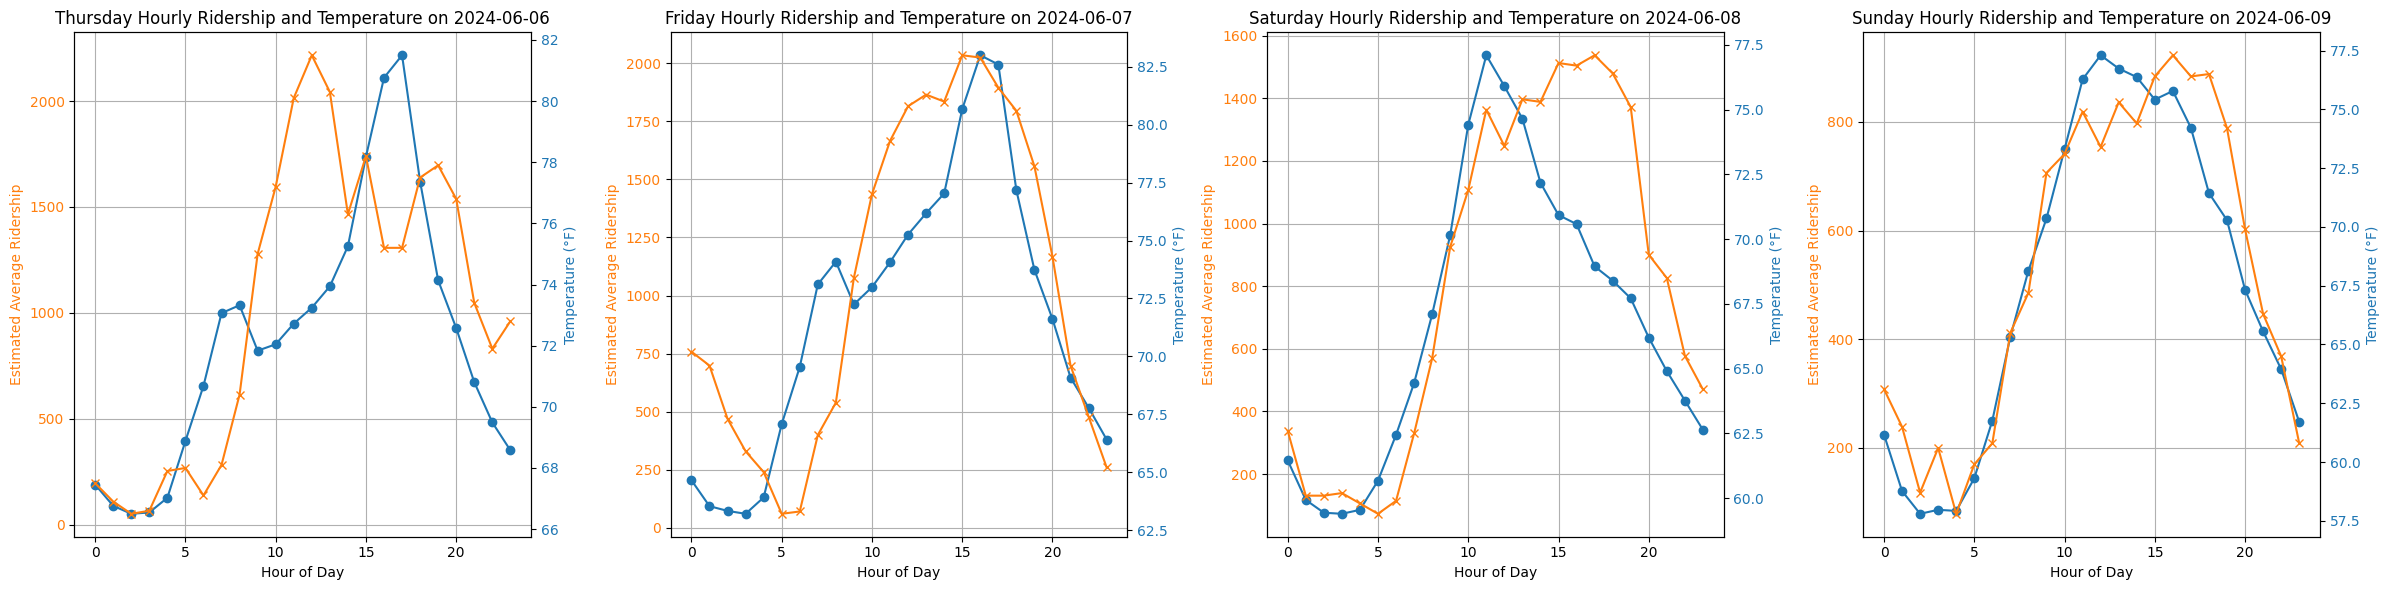

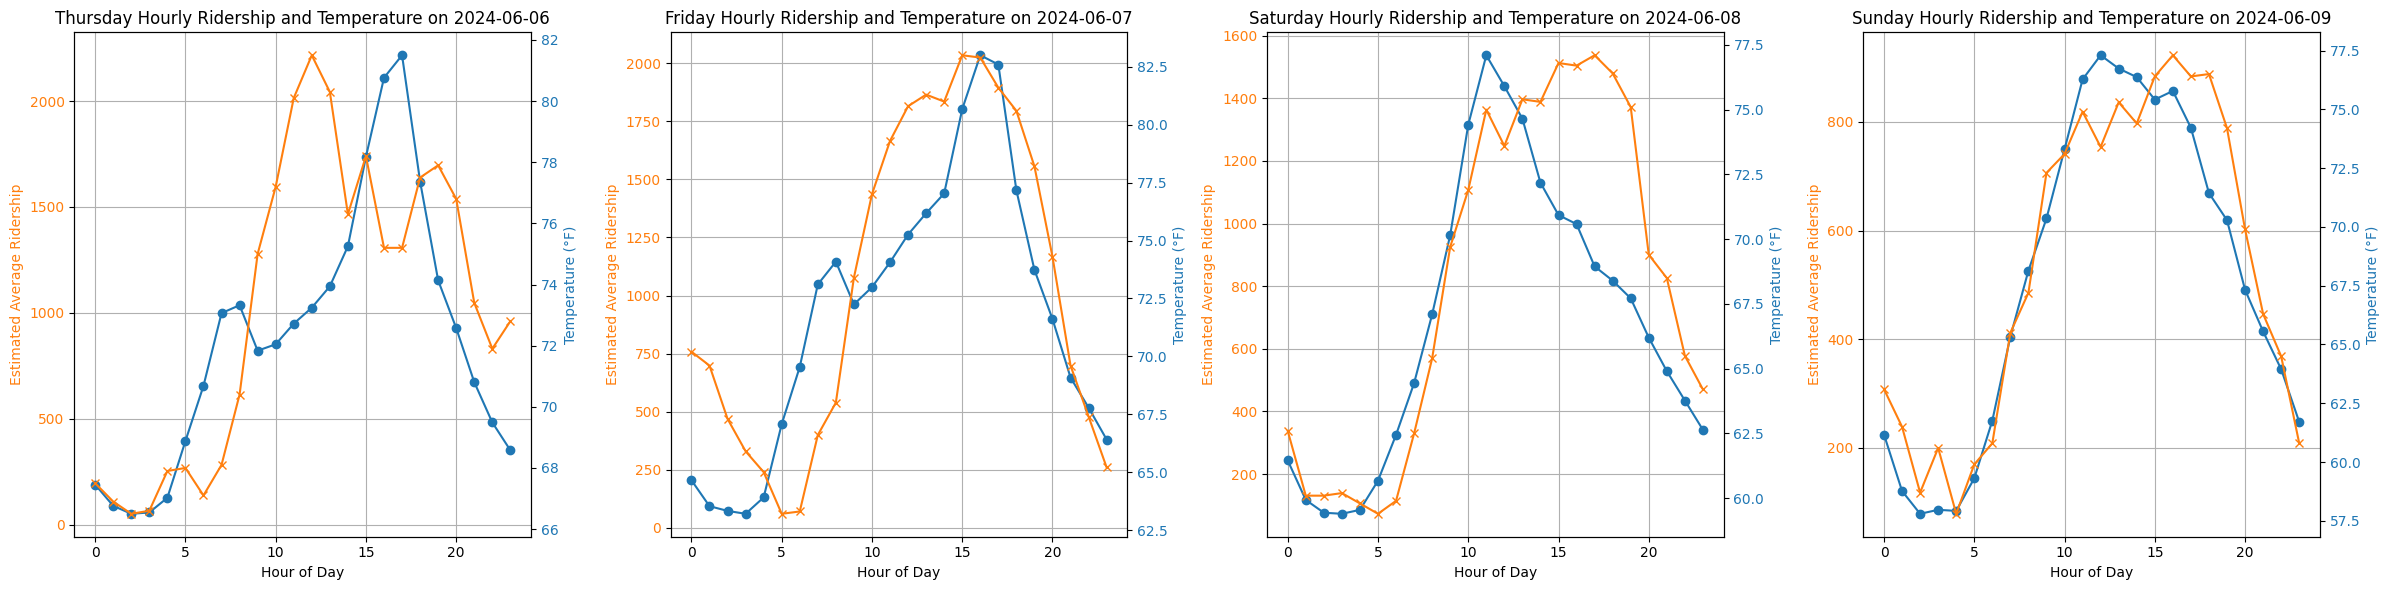

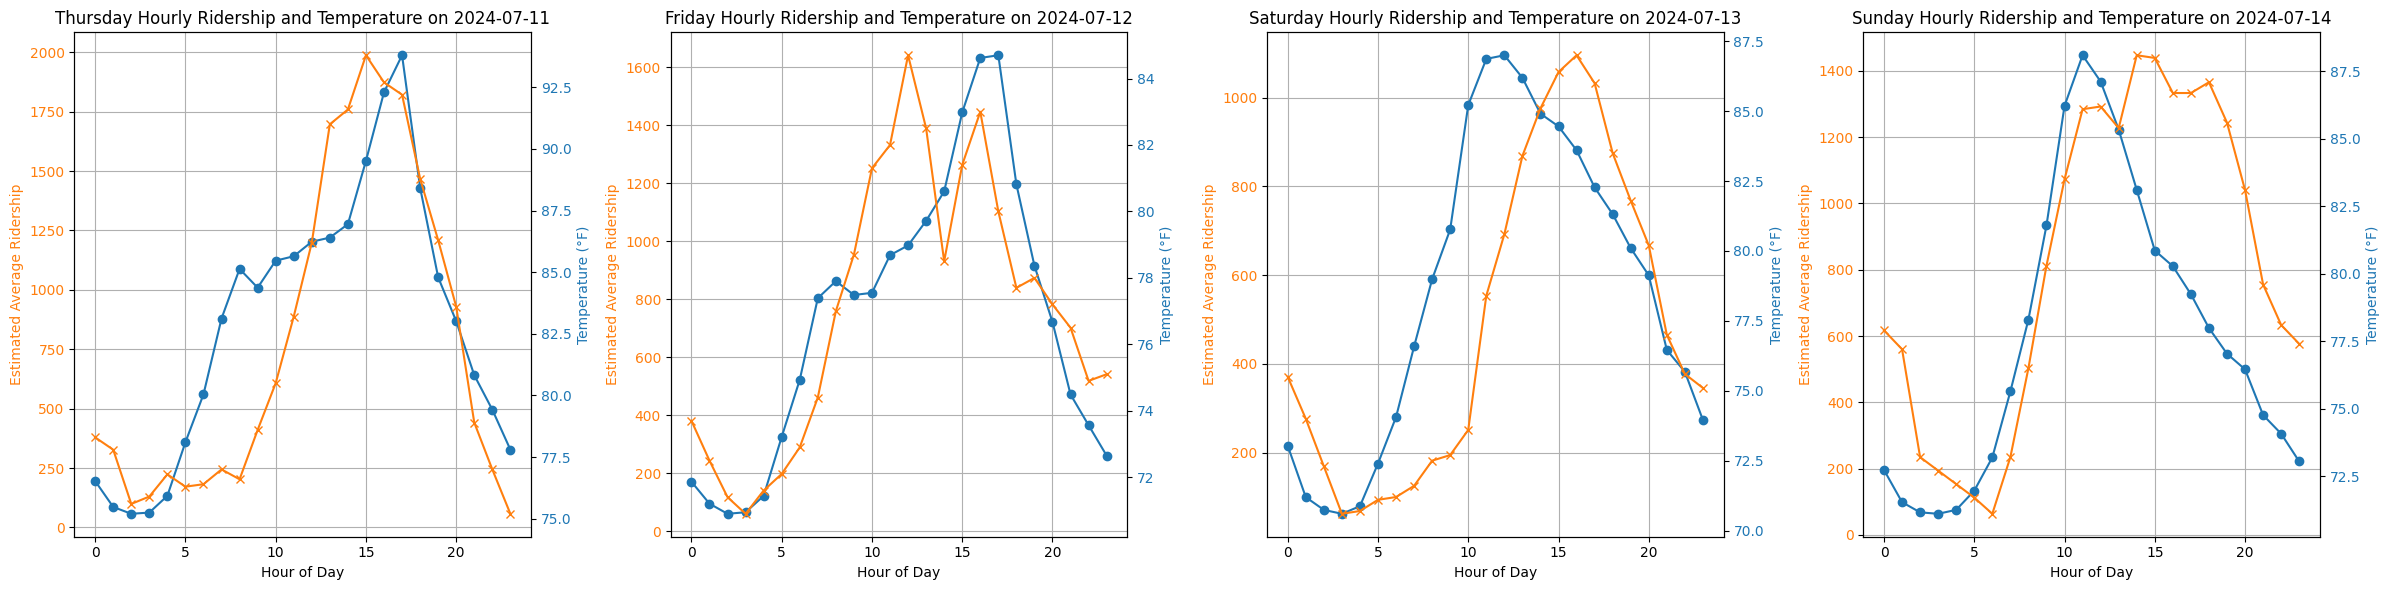

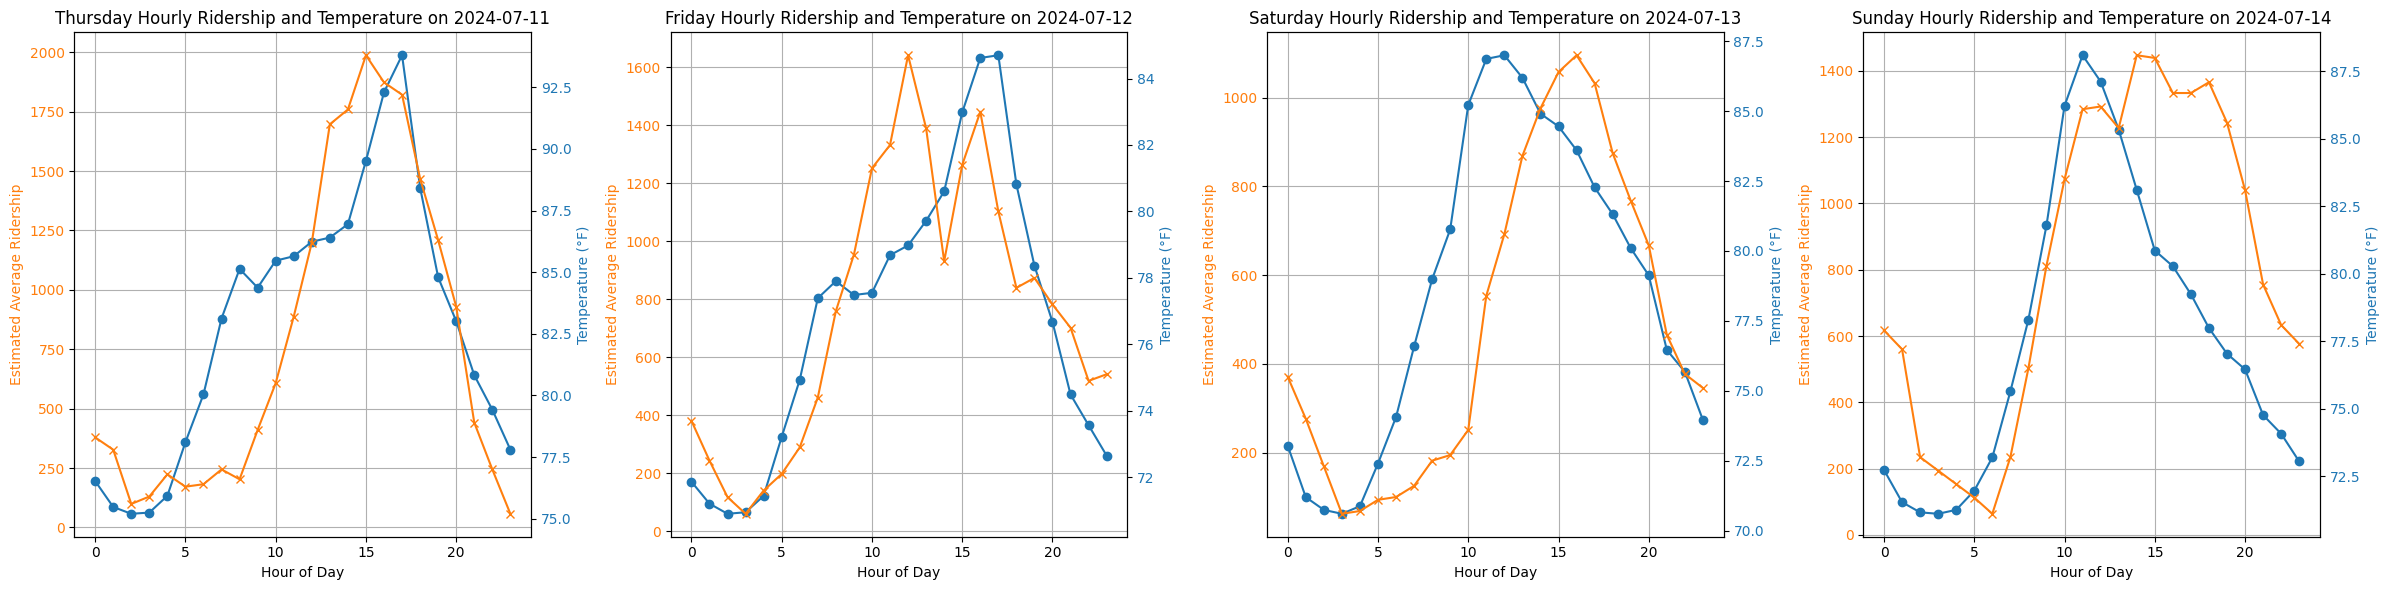

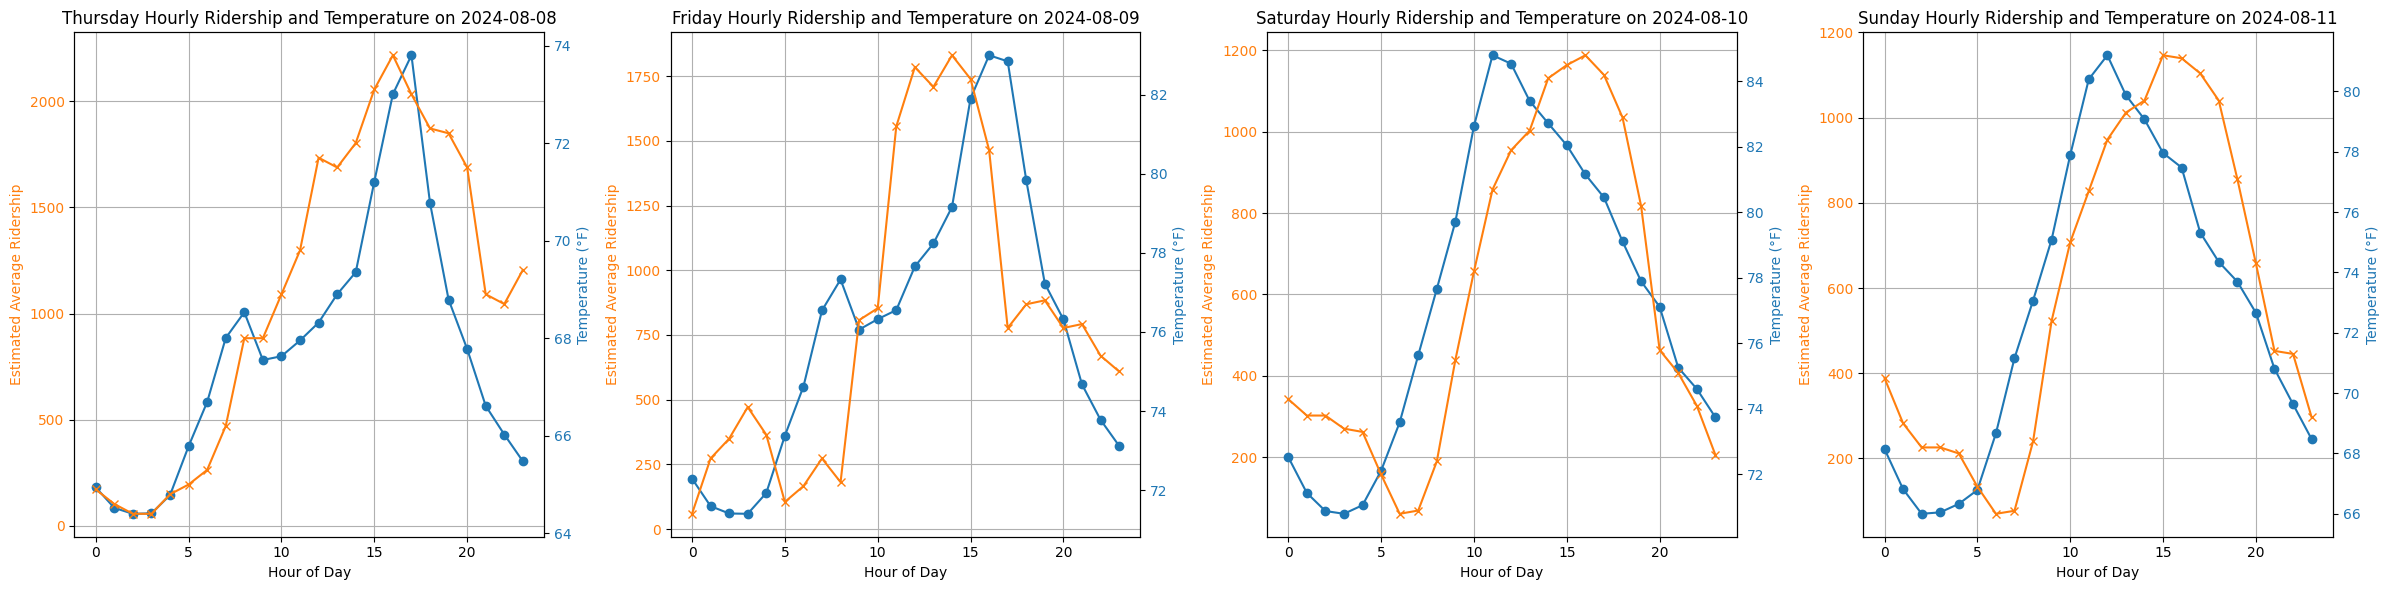

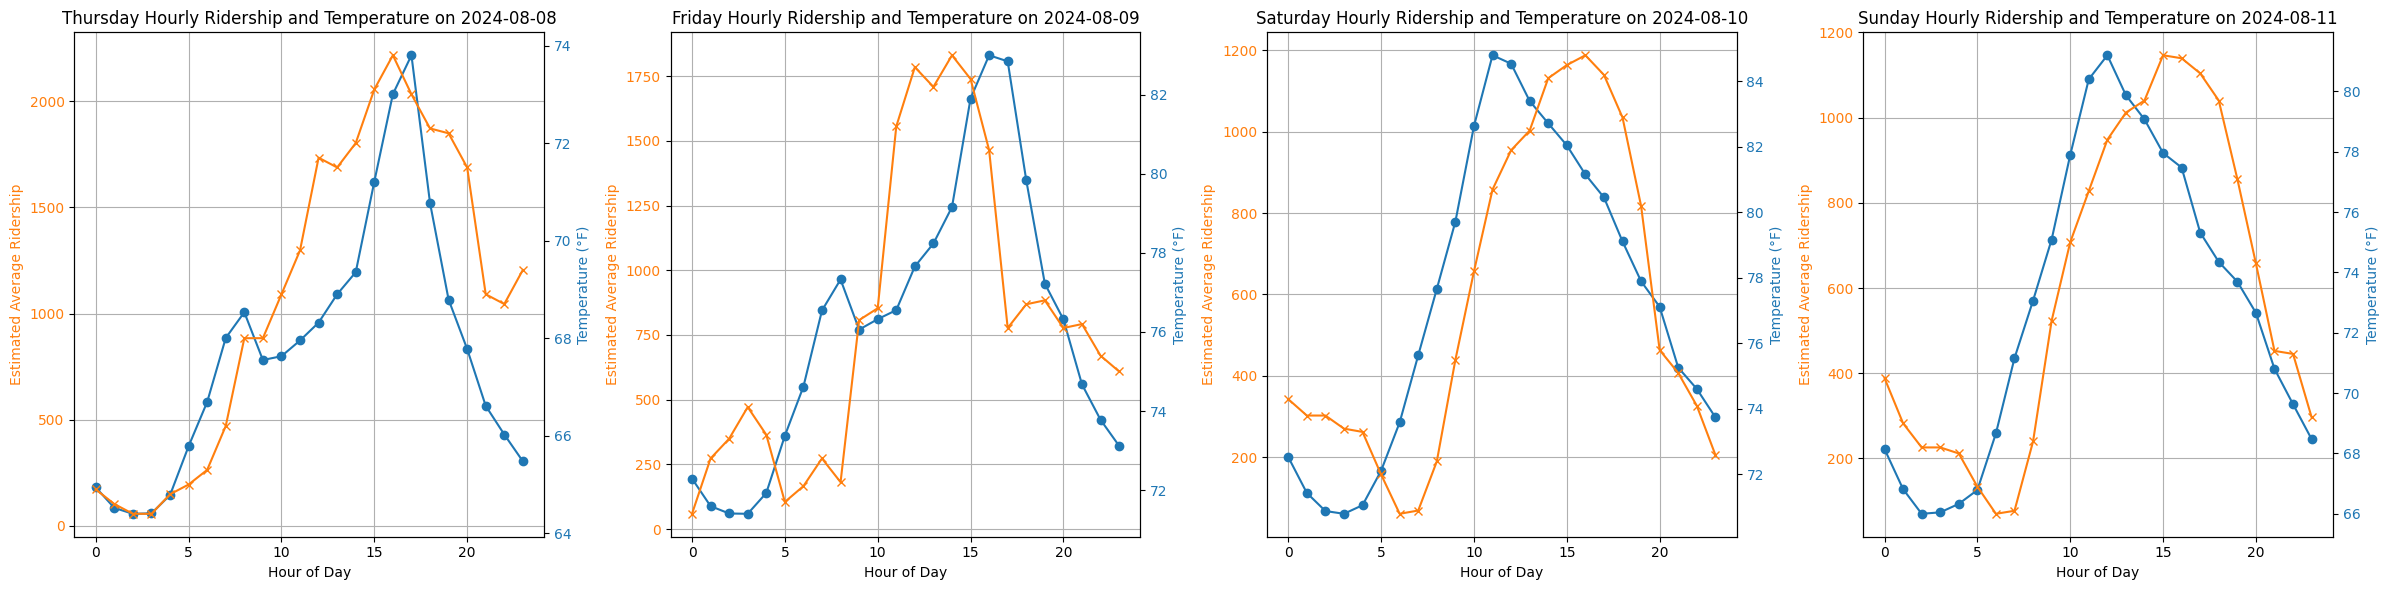

In [217]:
for dates in valid_high_temp_weekends:
    plot_ridership_and_temperature_for_dates(dates, beach_neighborhood_ridership, weather_summary)